<a href="https://colab.research.google.com/github/campofernando/lcqar-low-cost-monit-proc/blob/main/co-sensor-fix-monit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tratamento dos dados de CO adquiridos com o Monitor Fixo instalado na BU
- Período de medições: 
  - Primeira campanha: 14-03-2020 até 19-06-2020
  - Segunda campanha:  14-07-2020 até 03-09-2020
- Versão de HW: 0.0
- Versão de FW: 0.0

- Períodos de lockdown:
  - Primeiro lockdown: 19/03 - 17/06
  - Segundo lockdown: 20/07 - 10/08

## Anotações sobre tratamento e remoção de outliers tomadas do artigo de Ottosen e Kumar 2019:

### Tags de controle de qualidade dos dados de AQMesh

- Stabilizing: Stabilisation is a period whereby a sensor provides “bad” data due to not being in a state of equilibrium. Once the sensor settles in its environment after being recently moved in a manner which may shock or destabilise the sensor or after its being first installed, it will provide usable data. This process takes 2 days to complete for electrochemical sensors, 12 hours for NDIR and is not required for the OPC. (AQMesh Standard Operation Procedure Manual)

- Rebasing: The rebasing process standardises sensor output following the stabilisation of a sensor and is a vital stage before the start of a new project if there is any possibility that sensors have been destabilised. Sensors automatically rebase when first shipped by the manufacturer but after that, including if the pod is first switched on at a location other than the monitoring site, such as in an office, the process must be triggered manually. This will give the best possible pod-to-pod comparability and ‘out-of-the-box’ accuracy. ([AQMesh Standard Operation Procedure Manual](https://www.aqmesh.com/media/1dfhyw0h/standard-operating-procedure-v3-1.pdf)). Through this process AQMesh establishes a baseline for gas readings in a given environment –the pod is “zeroed”. The process by which this is done is complex and carried out on the cloud server. It is an important part of delivering accurate PreScaled data for ppb gas levels and needs to be completed in or near the intended measurement location (similar gas levels and environmental conditions). Rebasing the sensors directly affects the baseline of the sensor outputs, as such the offset between AQMesh and the reference instrument can differ before and after the rebasing process. ([AQMesh Rebasing Guidance](https://www.aqmesh.com/media/rdbf1ex0/rebasing-guidance.pdf))

- Greater than upper limit: didn't find any specification about this yet but I guess it should be related to sensor manufacturer specification. For example:
  - Alphasense CO-B4: 1.000 ppm = 1.000.000 ppb
  - SPEC DGS-CO:  1.000 ppm = 1.000.000 ppb

- Less than lower limit: similar to the previous, maybe related to negative values

- Valid: valid data

- N/A: suppose it's equivalent to NaN

### Tags de controle de qualidade dos dados de usados por Ottosen e Kumar 2019:

- Error: The erroneous measurements are seen as abrupt changes in the mean and/or the variance of the time series and have to be removed as part of the quality control. To detect these points, the Pruned Exact Linear Time (PELT) algorithm ([Killick, Fearnhead and Eckley 2011](https://doi.org/10.1080/01621459.2012.737745)), which is one of the commonly applied methods for change detection in time series, was used.

## Validade dos dados segundo o Guia de Monitoramento da Qualidade do Ar

- Média horária: 3/4 das medidas válidas na hora
- Média diária : 2/3 das médias horárias válidas no dia   - Média mensal*: 2/3 das médias diárias válidas no mês
- Média anual  : 1/2 das médias diárias válidas obtidas em cada quadrimestre (jan-abr; mai-ago; e set-dez)

## Monta Drive

## Importa bibliotecas

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from scipy import stats
from pathlib import Path
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

In [12]:
dataFolder1 = Path("data/raw-data-monit-fix-2020/camp-1")
dataFolder2 = Path("data/raw-data-monit-fix-2020/camp-2")

## Classes e funções para importação de dados e tratamento

Nesta versão os dados ainda não tinham a tag de status, por isso sempre serão removidos os dados entre as 7 e as 9 am

In [6]:
def validate_value(df, upper_limit, lower_limit):
  # df[0]: Value
  # df[1]: Tag
  if df[1] != 'VALID'   : return df[1]
  if (df[0] <= -9000.0  or 
      np.isnan(df[0]))  : return 'MISSING' 
  if df[0] < lower_limit: return 'LTLL'
  if df[0] > upper_limit: return 'GTUL'
  return 'VALID'

def validate_with_RH(df):
  # df[0]: Tag
  # df[1]: RH-TAG
  if df[0] != 'VALID'   : return df[0]
  if (df[1] == 'GTUL' or
      df[1] == 'LTLL')  : return 'BAD-RH'
  return 'VALID'

def validate_with_qtle(df):
  # df[0]: Value
  # df[1]: Tag
  # df[2]: QTLE01
  # df[3]: QTLE99
  # df[4]: VALID_HR_COUNT
  # df[5]: GLOBAL QTLE01
  # df[6]: GLOBAL QTLE99
  if df[1] != 'VALID'   : return df[1]
  if df[4]:
    if df[0] <= df[2]     : return 'LTQTLE01'
    if df[0] >= df[3]     : return 'GTQTLE99'
  else:
    if df[0] <= df[5]     : return 'LTQTLE01'
    if df[0] >= df[6]     : return 'GTQTLE99'
  return 'VALID'

def calculate_diff(df0,df1):
  # df0[0]: Tag of element i-1
  # df0[1]: Value of element i-1
  # df1[0]: Tag of element i
  # df1[1]: Value of element i
  if (df1[0] != 'VALID' or
      df0[0] != 'VALID')  : return 0
  #if (np.isnan(df1[1]) or
  #    np.isnan(df0[1]))  : return 0

  return df1[1] - df0[1]

def load_data(filename):
  date_time_col = ['Year','Month','Day','Hour','Minute','Second']
  var = pd.read_csv(filename)
  var['DateTime'] = (pd.to_datetime(var[date_time_col], 
                                    infer_datetime_format=False, 
                                    format='%d/%m/%Y/%H/%M/%S'))
  return (var.where(var['DateTime'] > dt.datetime(2020,1,1,0,0,0)).
              where(var['DateTime'] <= dt.datetime.now()).dropna())

def plot_box_hist(df, bins):
  bottom, height = 0.1, 0.65
  left, width = bottom, height*1.3
  spacing = 0.005
  
  rect_ser = [left-width-spacing, bottom, width, height]
  rect_box = [left, bottom, width, height]
  rect_hist = [left + width + spacing, bottom, height/1.3, height]

  plt.figure(figsize=(5, 5/1.3))

  ax_ser  = plt.axes(rect_ser)
  ax_ser.tick_params(direction='in', top=True, right=True)
  ax_ser.set_title('Serie temporal')

  ax_box  = plt.axes(rect_box)
  ax_box.tick_params(direction='in', labelleft=False)

  ax_hist = plt.axes(rect_hist)
  ax_hist.tick_params(direction='in', labelleft=False)
  ax_hist.set_title('Histograma')

  lim_max = df['Value'].max()+df['Value'].max()*10/100
  lim_min = df['Value'].min()-df['Value'].min()*10/100

  df['Value'].plot(ax=ax_ser)
  ax_ser.set_ylim(lim_min, lim_max)

  ax_hist.hist(df['Value'], bins=bins, orientation='horizontal')
  ax_hist.set_ylim(lim_min, lim_max)

  df = df.dropna(axis='index', how='all', subset=['Hour'])
  df['Hour'] = df['Hour'].astype('int64')
  df.pivot(columns='Hour')['Value'].dropna(
        axis='columns', how='all').plot.box(
            ax=ax_box,title='Comportamento médio no período')
  ax_box.set_ylim(ax_hist.get_ylim())

def count_tags(tags_list, df):
  tags_list.append('TOTAL')
  count = len(df)
  data_count = pd.DataFrame(index=tags_list, columns=['#', '%'])
  data_count.loc['TOTAL'] = [count, (count/count)*100]

  for tag in data_count.index[:-1]:
    val = (df.where(df['Tag'] == tag)
              .count()['Tag'])  # Fiz assim pq count() não conta os nan
    data_count.loc[tag] = [val, (val/count)*100]

  return data_count

def calc_mean_hr(data):
    data = (data.groupby(by=['Year', 'Month', 'Day', 'Hour']).mean().
            drop(columns=['Minute','Second']))
    indexes = [ dt.datetime(int(i[0]), int(i[1]), int(i[2]), int(i[3])) 
               for i in data.index]
    data.index = indexes
    return data

def calc_mean_diurnal(data):
    data = (data.groupby(by=['Hour']).mean().
            drop(columns=['Year', 'Month', 'Day', 'Minute','Second']))
    return data

def calc_std_diurnal(data):
    data = (data.groupby(by=['Hour']).std().
            drop(columns=['Year', 'Month', 'Day', 'Minute','Second']))
    return data

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
# Function for double exponential smoothing
def double_exp_smoothing(x, alpha, beta):
  yhat = [x[0]] # first value is same as series
  for t in range(1, len(x)):
    if t==1:  F, T= x[0], x[1] - x[0]
    F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
    T=beta*(F-F_n_1)+(1-beta)*T
    yhat.append(F+T)
  return yhat

## Upload dos dados

### Upload dos dados Monóxido Carbono Sensor SPEC

In [7]:
dados_SPEC_1 = load_data(filename=dataFolder1.joinpath("CO_LOG.CSV"))
dados_SPEC_1 = dados_SPEC_1.where(dados_SPEC_1['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_SPEC_1 = (dados_SPEC_1.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_SPEC_1.index=dados_SPEC_1['DateTime']
dados_SPEC_1 = dados_SPEC_1.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_SPEC_1 = dados_SPEC_1.resample('2T').mean() # dados cada 2 mins
#dados_SPEC = dados_SPEC.resample('15T').mean() # dados cada 15 mins
dados_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,1.0,20.0,4.0,8.0,0.0,5348.33
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,3.0,20.0,4.0,8.0,0.0,5590.00
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,5.0,21.0,4.0,8.0,0.0,5781.17
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,7.0,22.0,4.0,8.0,0.0,5319.17
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,9.0,25.0,4.0,8.0,0.0,5775.00


In [13]:
dados_SPEC_2 = load_data(filename=dataFolder2.joinpath("CO_LOG.CSV"))
dados_SPEC_2 = dados_SPEC_2.where(dados_SPEC_2['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_SPEC_2 = (dados_SPEC_2.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_SPEC_2.index=dados_SPEC_2['DateTime']
dados_SPEC_2 = dados_SPEC_2.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_SPEC_2 = dados_SPEC_2.resample('2T').mean() # dados cada 2 mins
dados_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,36.0,4.0,0.0,8.0,0.000
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,37.0,4.0,0.0,8.0,482.665
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,38.0,4.0,0.0,8.0,1118.585
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,38.5,4.0,0.0,8.0,1715.085
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Upload dos dados Monóxido Carbono Sensor Alphasense

In [8]:
dados_Alpha_1 = load_data(filename=dataFolder1.joinpath("ISB_CO.CSV"))
dados_Alpha_1 = dados_Alpha_1.where(dados_Alpha_1['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_Alpha_1 = (dados_Alpha_1.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_Alpha_1.index=dados_Alpha_1['DateTime']
dados_Alpha_1 = dados_Alpha_1.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_Alpha_1 = dados_Alpha_1.resample('2T').mean() # dados cada 2 mins
dados_Alpha_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,39.0,4.0,40.0,0.0,575.46
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,40.0,4.0,40.0,0.0,597.15
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,41.0,4.0,40.0,0.0,603.74
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,42.0,4.0,40.0,0.0,606.29
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,45.0,4.0,40.0,0.0,552.08


In [14]:
dados_Alpha_2 = load_data(filename=dataFolder2.joinpath("ISB_CO.CSV"))
dados_Alpha_2 = dados_Alpha_2.where(dados_Alpha_2['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_Alpha_2 = (dados_Alpha_2.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_Alpha_2.index=dados_Alpha_2['DateTime']
dados_Alpha_2 = dados_Alpha_2.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_Alpha_2 = dados_Alpha_2.resample('2T').mean() # dados cada 2 mins
dados_Alpha_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,21.0,4.0,0.0,40.0,0.000
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,22.0,4.0,0.0,40.0,1245.865
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,23.0,4.0,0.0,40.0,851.550
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,23.5,4.0,0.0,40.0,546.470
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plota raw de SPEC e Alphasense

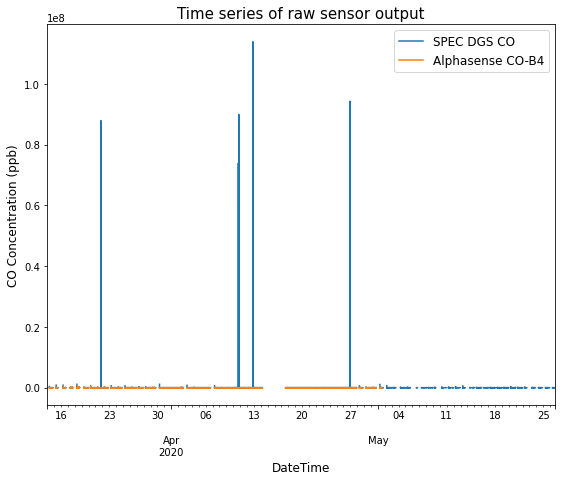

In [11]:
dados_SPEC_1['Value'].plot(figsize=(7*1.3,7))
plt.title('Time series of raw sensor output', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('CO Concentration (ppb)', fontsize=12)
dados_Alpha_1['Value'].plot()
plt.legend(['SPEC DGS CO', 'Alphasense CO-B4'], 
           prop={'size': 12})

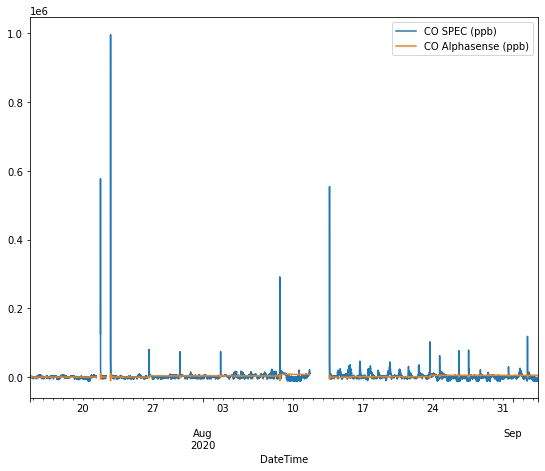

In [15]:
dados_SPEC_2['Value'].plot(figsize=(7*1.3,7))
dados_Alpha_2['Value'].plot()
plt.legend(['CO SPEC (ppb)', 'CO Alphasense (ppb)'])

### Upload dos dados de Umidade Relativa - Campanha 1

In [16]:
dados_RH_SPEC_1 = load_data(filename=dataFolder1.joinpath("RH_LOG.CSV"))
dados_RH_SPEC_1 = dados_RH_SPEC_1.where(dados_RH_SPEC_1['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_RH_SPEC_1 = (dados_RH_SPEC_1.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_RH_SPEC_1.index=dados_RH_SPEC_1['DateTime']
dados_RH_SPEC_1 = dados_RH_SPEC_1.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_RH_SPEC_1 = dados_RH_SPEC_1.resample('2T').mean() # dados cada 2 mins
dados_RH_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,9.0,4.0,13.0,0.0,84.33
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,10.0,4.0,13.0,0.0,84.33
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,11.0,4.0,13.0,0.0,85.00
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,11.0,4.0,13.0,0.0,84.50
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,15.0,4.0,13.0,0.0,82.33


### Upload dos dados de Umidade Relativa - Campanha 2

In [17]:
dados_RH_SPEC_2 = load_data(filename=dataFolder2.joinpath("RH_LOG.CSV"))
dados_RH_SPEC_2 = dados_RH_SPEC_2.where(dados_RH_SPEC_2['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_RH_SPEC_2 = (dados_RH_SPEC_2.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_RH_SPEC_2.index=dados_RH_SPEC_2['DateTime']
dados_RH_SPEC_2 = dados_RH_SPEC_2.drop(columns=['DateTime', 'Latitude', 'Longitude', 
                                      'Altitude'])

dados_RH_SPEC_2 = dados_RH_SPEC_2.resample('2T').mean() # dados cada 2 mins
dados_RH_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value
DateTime,,,,,,,,,,
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,2.5,4.0,0.0,13.0,63.00
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,3.0,4.0,0.0,13.0,67.75
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,3.5,4.0,0.0,13.0,67.67
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-14 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plota raw de Umidade relativa

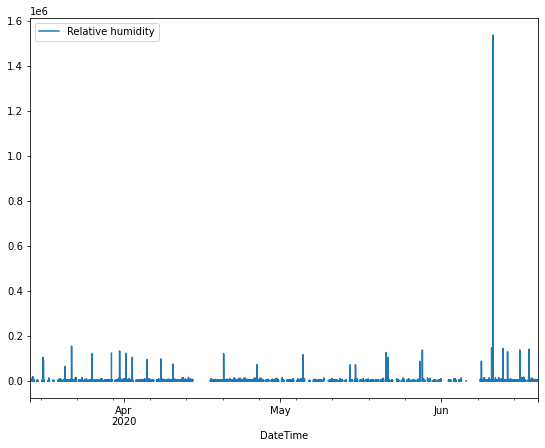

In [18]:
dados_RH_SPEC_1['Value'].plot(figsize=(7*1.3,7))
plt.legend(['Relative humidity'])

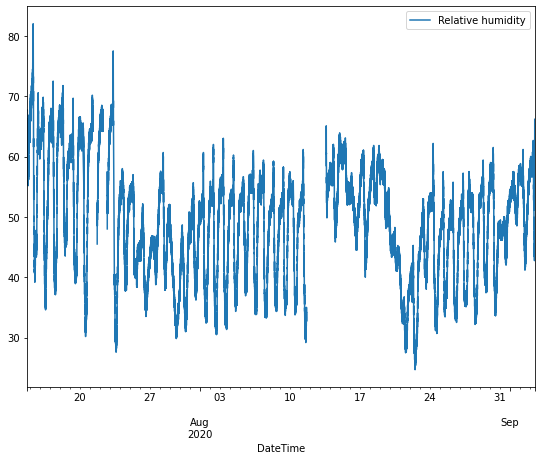

In [19]:
dados_RH_SPEC_2['Value'].plot(figsize=(7*1.3,7))
plt.legend(['Relative humidity'])

#### Etiqueta dados de Umidade

,#,%
STABILZ,4081,5.809749
VALID,66163,94.190251
TOTAL,70244,100.0


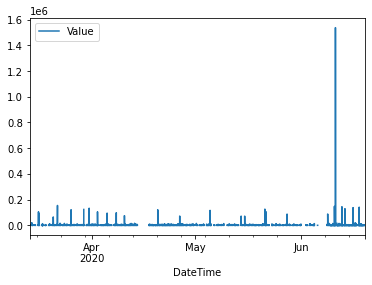

In [20]:
# Remove outlier das 07H00
dados_RH_SPEC_1['Tag'] = dados_RH_SPEC_1['Hour'].map(
    lambda h: 'STABILZ' if (h >= 6 and h <= 8) else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_RH_SPEC_1)

(dados_RH_SPEC_1[dados_RH_SPEC_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
STABILZ,130,0.355638
VALID,36424,99.644362
TOTAL,36554,100.0


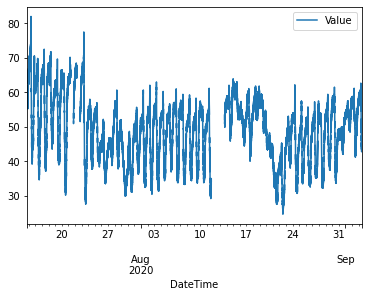

In [21]:
# Remove outlier das 07H00
dados_RH_SPEC_2['Tag'] = dados_RH_SPEC_2['DeviceSt'].map(
    lambda st: 'STABILZ' if st%2 <= 0 else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_RH_SPEC_2)

(dados_RH_SPEC_2[dados_RH_SPEC_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

In [22]:
dados_RH_SPEC_1['Tag'] = (dados_RH_SPEC_1[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 100, 0.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_RH_SPEC_1)

dados_RH_1 = (dados_RH_SPEC_1.where(dados_RH_SPEC_1['Tag'].eq('VALID')).dropna().
            resample('2T').mean())

dados_RH_1.head()
data_contabilization

,#,%
MISSING,26142,37.21599
STABILZ,4081,5.809749
LTLL,0,0.0
GTUL,1552,2.209441
VALID,38469,54.76482
TOTAL,70244,100.0


In [ ]:
dados_RH_SPEC_2['Tag'] = (dados_RH_SPEC_2[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 100, 0.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_RH_SPEC_2)

dados_RH_2 = (dados_RH_SPEC_2.where(dados_RH_SPEC_2['Tag'].eq('VALID')).dropna().
            resample('2T').mean())

dados_RH_2.head()
data_contabilization

,#,%
MISSING,2050,5.60814
STABILZ,130,0.355638
LTLL,0,0
GTUL,0,0
VALID,34374,94.0362
TOTAL,36554,100


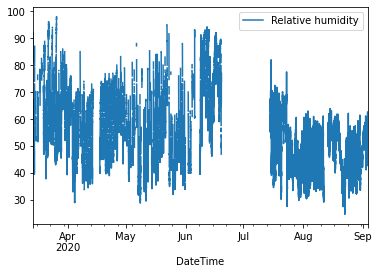

In [ ]:
dados_RH = (pd.concat([dados_RH_1, dados_RH_2]).dropna().resample('2T')
            .mean())
dados_RH['Value'].plot()
plt.legend(['Relative humidity'])

### Manipulação dos dados SPEC

#### Acrescenta valores de RH e suas etiquetas

In [35]:
dados_SPEC_1['RH SPEC'] = dados_RH_SPEC_1.loc[dados_SPEC_1.index]['Value']
dados_SPEC_1['RH Tag'] = dados_RH_SPEC_1.loc[dados_SPEC_1.index]['Tag']
dados_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag
DateTime,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,1.0,20.0,4.0,8.0,0.0,5348.33,84.33,VALID
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,3.0,20.0,4.0,8.0,0.0,5590.00,84.33,VALID
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,5.0,21.0,4.0,8.0,0.0,5781.17,85.00,VALID
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,7.0,22.0,4.0,8.0,0.0,5319.17,84.50,VALID
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,9.0,25.0,4.0,8.0,0.0,5775.00,82.33,VALID


In [36]:
dados_SPEC_2['RH SPEC'] = dados_RH_SPEC_2.loc[dados_SPEC_2.index[1:]]['Value']
dados_SPEC_2['RH Tag'] = dados_RH_SPEC_2.loc[dados_SPEC_2.index[1:]]['Tag']
dados_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag
DateTime,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,36.0,4.0,0.0,8.0,0.000,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,37.0,4.0,0.0,8.0,482.665,63.00,STABILZ
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,38.0,4.0,0.0,8.0,1118.585,67.75,STABILZ
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,38.5,4.0,0.0,8.0,1715.085,67.67,STABILZ
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING


#### Etiqueta dados de Monóxido de Carbono SPEC

,#,%
STABILZ,3341,6.295103
VALID,49732,93.704897
TOTAL,53073,100.0


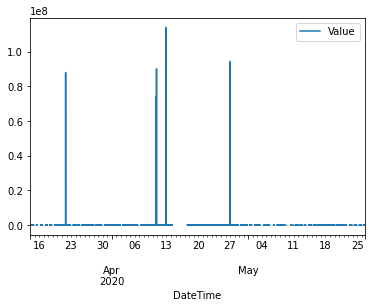

In [37]:
# Remove outlier das 07H00
dados_SPEC_1['Tag'] = dados_SPEC_1['Hour'].map(
    lambda h: 'STABILZ' if (h >= 6 and h <= 8) else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_SPEC_1)

(dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
STABILZ,133,0.363835
VALID,36422,99.636165
TOTAL,36555,100.0


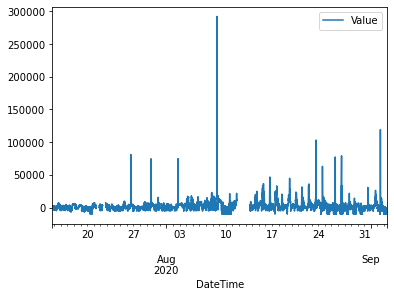

In [38]:
# Remove outlier das 07H00
dados_SPEC_2['Tag'] = dados_SPEC_2['DeviceSt'].map(
    lambda st: 'STABILZ' if st%2 <= 0 else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_SPEC_2)

(dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,18813,35.447403
STABILZ,3341,6.295103
LTLL,5628,10.604262
GTUL,5,0.009421
VALID,25286,47.643811
TOTAL,53073,100.0


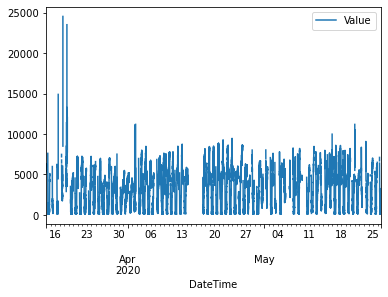

In [39]:
dados_SPEC_1['Tag'] = (dados_SPEC_1[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 1e6, 100.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_SPEC_1)
(dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))

data_contabilization

,#,%
MISSING,2998,8.20134
STABILZ,133,0.363835
LTLL,8343,22.823143
GTUL,0,0.0
VALID,25081,68.611681
TOTAL,36555,100.0


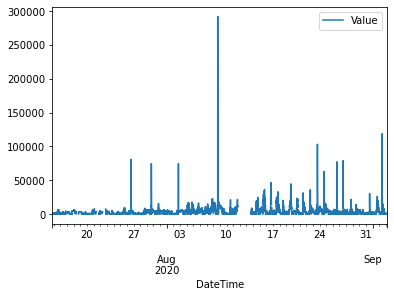

In [40]:
dados_SPEC_2['Tag'] = (dados_SPEC_2[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 1e6, 100.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_SPEC_2)
(dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))

data_contabilization

,#,%
MISSING,18813,35.447403
STABILZ,3341,6.295103
LTLL,5628,10.604262
GTUL,5,0.009421
BAD-RH,947,1.784335
VALID,24339,45.859477
TOTAL,53073,100.0


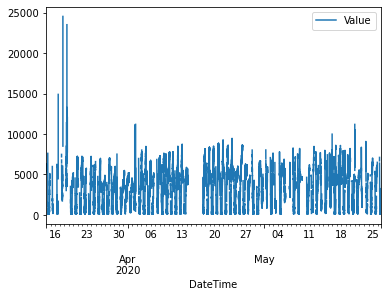

In [41]:
dados_SPEC_1['Tag'] = (dados_SPEC_1[['Tag', 'RH Tag']]
                     .apply(lambda v: validate_with_RH(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'VALID'], 
                                  dados_SPEC_1)
(dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,2998,8.20134
STABILZ,133,0.363835
LTLL,8343,22.823143
GTUL,0,0.0
BAD-RH,0,0.0
VALID,25081,68.611681
TOTAL,36555,100.0


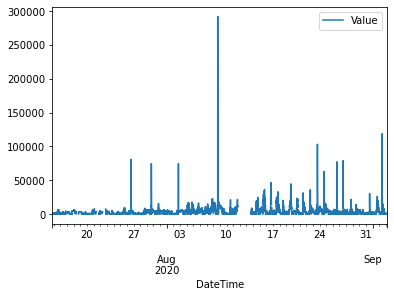

In [42]:
dados_SPEC_2['Tag'] = (dados_SPEC_2[['Tag', 'RH Tag']]
                     .apply(lambda v: validate_with_RH(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'VALID'], 
                                  dados_SPEC_2)
(dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

#### Cálculo de derivada

<AxesSubplot:xlabel='DateTime'>

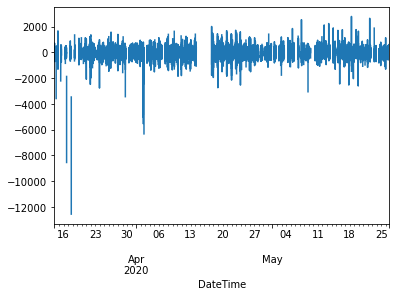

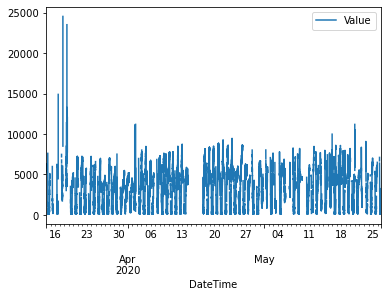

In [43]:
dados_SPEC_Valid_1 = dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('2T').mean()
dados_SPEC_1['Value Diff'] = dados_SPEC_Valid_1['Value'].diff()
dados_SPEC_1['Value Diff'].plot()
dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('2T').mean().plot(y='Value')

Os valores obtidos de derivadas estão dentro dos limites do tempo de resposta dos sensores

### Reamostragem horária dos dados

#### Calcula média, desvio padrão e número de dados válidos por hora

In [44]:
dados_SPEC_1_HR = dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].resample('H').mean()
dados_SPEC_1_HR['Count'] = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].
                            resample('H').count()['Value'])
dados_SPEC_1_HR['Std'] = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID'].
                          resample('H').std()['Value'])
dados_SPEC_1_HR['% valid'] = (dados_SPEC_1_HR['Count'].
                              map(lambda c: 
                                  c/(pd.Timedelta("1 hour")/dados_SPEC_1.index.freq)*100))
dados_SPEC_1_HR['Tag'] = (dados_SPEC_1_HR['% valid'].
                              map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))
dados_SPEC_1_HR.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,Value Diff,Count,Std,% valid,Tag
DateTime,,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,29.344828,30.758621,4.0,8.0,0.0,5756.345862,88.005517,9.574444,29,205.901874,96.666667,VALID
2020-03-14 01:00:00,2020.0,3.0,14.0,1.0,8.000000,29.500000,4.0,8.0,0.0,5945.062500,86.602500,5.041250,8,295.047330,26.666667,LOWSAMPLES
2020-03-14 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,LOWSAMPLES
2020-03-14 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,LOWSAMPLES
2020-03-14 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,LOWSAMPLES


#### Plota média vs. desvio padrão e contagem dos dados


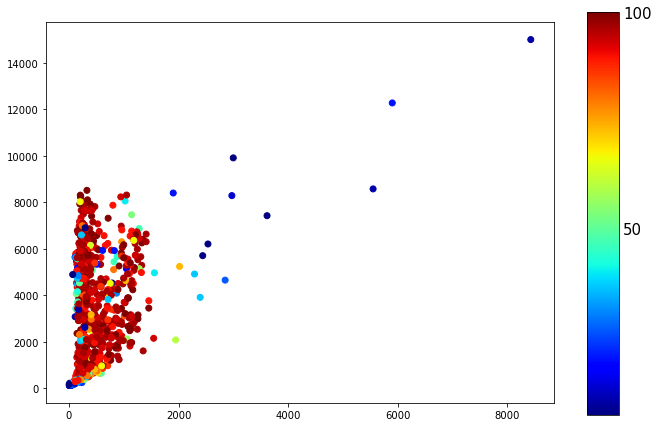

In [45]:
fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_1_HR['Std'], dados_SPEC_1_HR['Value'], 
            c=dados_SPEC_1_HR['% valid'], cmap='jet')
cax = plt.axes([0.95, 0.1, 0.05
                , 0.8])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_1_HR['% valid'].min()+1),
         np.int64((dados_SPEC_1_HR['% valid'].max()
         -dados_SPEC_1_HR['% valid'].min())/2),
         np.int64(dados_SPEC_1_HR['% valid'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

#### Plota desvio padrão no tempo e porcentagem de dados válidos em uma hora

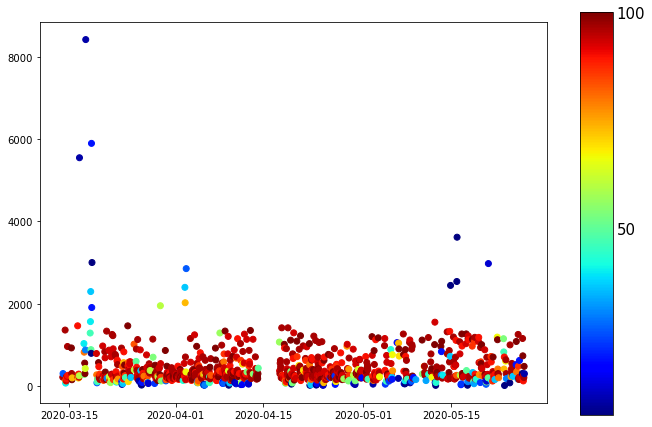

In [46]:
fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_1_HR.index, dados_SPEC_1_HR['Std'], 
            c=dados_SPEC_1_HR['% valid'], cmap='jet')
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_1_HR['% valid'].min()+1),
         np.int64((dados_SPEC_1_HR['% valid'].max()
         -dados_SPEC_1_HR['% valid'].min())/2),
         np.int64(dados_SPEC_1_HR['% valid'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

#### Plota média vs. desvio padrão depois de remover as horas com < 75% de dados válidos

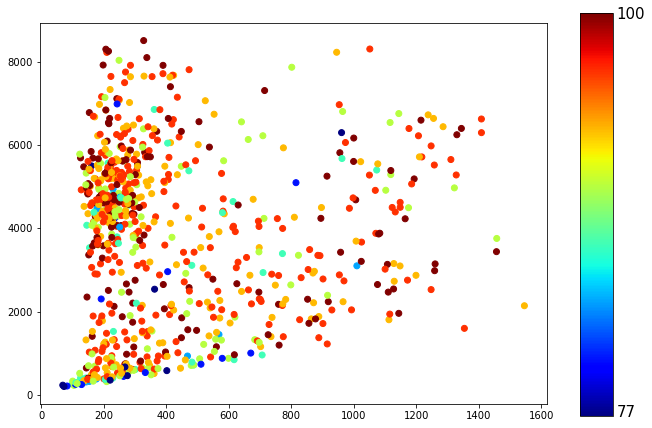

In [47]:
fig = plt.figure(figsize=(1.3*7,7))
plot_data = dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID'].resample('H').mean()
plt.scatter(plot_data['Std'], plot_data['Value'], 
            c=plot_data['% valid'], cmap='jet')
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(plot_data['% valid'].min()+1),
         np.int64((plot_data['% valid'].max()
         -plot_data['% valid'].min())/2),
         np.int64(plot_data['% valid'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

#### Plota desvio padrão no tempo e porcentagem de dados válidos em uma hora depois de remover as horas com < 75% de dados válidos

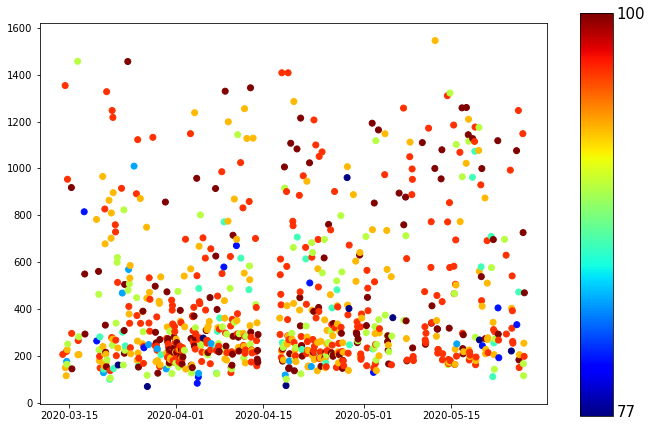

In [48]:
fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(plot_data.index, plot_data['Std'], 
            c=plot_data['% valid'], cmap='jet')
cax = plt.axes([0.95, 0.1, 0.05, 0.8])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(plot_data['% valid'].min()+1),
         np.int64((plot_data['% valid'].max()
         -plot_data['% valid'].min())/2),
         np.int64(plot_data['% valid'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

/home/fernando/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


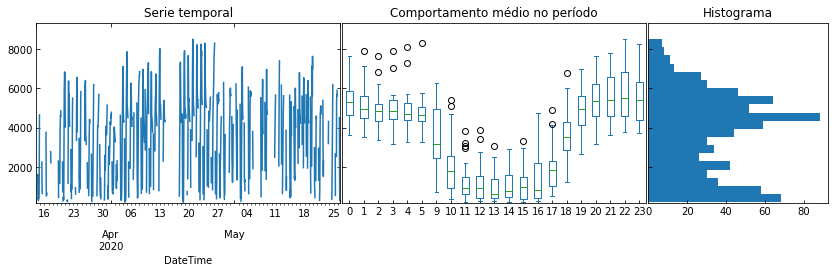

In [52]:
plot_box_hist(dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID'].resample('1H').mean(), 20)

#### Plota dados válidos horários SPEC vs Umidade Relativa

Spearmans correlation coefficient: 0.404
Samples are correlated (reject H0) p=0.000


NameError: name 'dados_SPEC_valid_1' is not defined

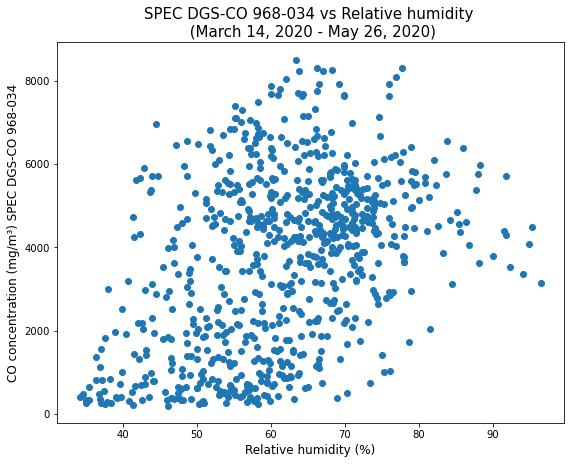

In [53]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['RH SPEC'], 
    dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['Value'])
plt.title('SPEC DGS-CO 968-034 vs Relative humidity \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Relative humidity (%)', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) SPEC DGS-CO 968-034', 
           fontsize=12)
coef, p = spearmanr(dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['RH SPEC'], 
                    dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['Value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau( dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['RH SPEC'], 
                            dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID']['Value'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

Separar data em dois grupos: Day (10 - 17), Night (00 - 05, 19 - 23)

In [ ]:
plot_box_hist(dados_SPEC_1_HR[dados_SPEC_1_HR['Tag'] == 'VALID'].resample('1H').mean(), 20)

#### Calcula quartís por hora SPEC 1

In [ ]:
qtle_01 = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.01, interpolation='lower'))
qtle_99 = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.99, interpolation='higher'))

qtle_01 = qtle_01.resample('2T').pad()
qtle_99 = qtle_99.resample('2T').pad()
dados_SPEC_1['QTLE01'] = qtle_01[qtle_01.index >= dados_SPEC_1.index[0]]
dados_SPEC_1['QTLE99'] = qtle_99[qtle_99.index >= dados_SPEC_1.index[0]]
dados_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99
DateTime,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,1.0,20.0,4.0,8.0,0.0,5348.33,84.33,VALID,VALID,5319.17,6313.5
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,3.0,20.0,4.0,8.0,0.0,5590.00,84.33,VALID,VALID,5319.17,6313.5
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,5.0,21.0,4.0,8.0,0.0,5781.17,85.00,VALID,VALID,5319.17,6313.5
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,7.0,22.0,4.0,8.0,0.0,5319.17,84.50,VALID,VALID,5319.17,6313.5
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,9.0,25.0,4.0,8.0,0.0,5775.00,82.33,VALID,VALID,5319.17,6313.5


#### Conta dados por hora

In [ ]:
valid_hr_count = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID']['Value']
           .resample('1H').count())
dados_SPEC_1['VALID_HR_COUNT'] = valid_hr_count.resample('2T').pad() >= 23  
                                    # 1 hour / 2 min = 30 samples
                                    # 22.5 = 75% of 30
dados_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT
DateTime,,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,1.0,20.0,4.0,8.0,0.0,5348.33,84.33,VALID,VALID,5319.17,6313.5,True
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,3.0,20.0,4.0,8.0,0.0,5590.00,84.33,VALID,VALID,5319.17,6313.5,True
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,5.0,21.0,4.0,8.0,0.0,5781.17,85.00,VALID,VALID,5319.17,6313.5,True
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,7.0,22.0,4.0,8.0,0.0,5319.17,84.50,VALID,VALID,5319.17,6313.5,True
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,9.0,25.0,4.0,8.0,0.0,5775.00,82.33,VALID,VALID,5319.17,6313.5,True


#### Calcula quartís por hora para todo o período

In [ ]:
global_qtle_01 = dados_SPEC_1.pivot(columns='Hour')['Value'].quantile(
    q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dados_SPEC_1.pivot(columns='Hour')['Value'].quantile(
    q=0.99, axis='index', interpolation='higher').dropna()

dados_SPEC_1['GLOBAL QTLE01'] = dados_SPEC_1['Hour'].map(
    lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dados_SPEC_1['GLOBAL QTLE99'] = dados_SPEC_1['Hour'].map(
    lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)

dados_SPEC_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,1.0,20.0,4.0,8.0,0.0,5348.33,84.33,VALID,VALID,5319.17,6313.5,True,3397.33,7909.83
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,3.0,20.0,4.0,8.0,0.0,5590.00,84.33,VALID,VALID,5319.17,6313.5,True,3397.33,7909.83
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,5.0,21.0,4.0,8.0,0.0,5781.17,85.00,VALID,VALID,5319.17,6313.5,True,3397.33,7909.83
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,7.0,22.0,4.0,8.0,0.0,5319.17,84.50,VALID,VALID,5319.17,6313.5,True,3397.33,7909.83
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,9.0,25.0,4.0,8.0,0.0,5775.00,82.33,VALID,VALID,5319.17,6313.5,True,3397.33,7909.83


#### Etiqueta dados por quartís

In [ ]:
dados_SPEC_1['Tag'] = (dados_SPEC_1[['Value','Tag','QTLE01','QTLE99',
                                         'VALID_HR_COUNT', 'GLOBAL QTLE01',
                                         'GLOBAL QTLE99']]
                     .apply(lambda v: validate_with_qtle(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'LTQTLE01', 'GTQTLE99',
                                   'VALID'], dados_SPEC_1)

dados_SPEC_valid_1 = (dados_SPEC_1[dados_SPEC_1['Tag'] == 'VALID']
                        .resample('15T').mean()).copy()
data_contabilization

,#,%
MISSING,18813,35.4474
STABILZ,3341,6.2951
LTLL,5628,10.6043
GTUL,5,0.00942099
BAD-RH,947,1.78433
LTQTLE01,776,1.46214
GTQTLE99,888,1.67317
VALID,22675,42.7242
TOTAL,53073,100


#### Calcula quartís por hora SPEC 2

In [ ]:
qtle_01 = (dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.01, interpolation='lower'))
qtle_99 = (dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.99, interpolation='higher'))

qtle_01 = qtle_01.resample('2T').pad()
qtle_99 = qtle_99.resample('2T').pad()
dados_SPEC_2['QTLE01'] = qtle_01[qtle_01.index >= dados_SPEC_2.index[0]]
dados_SPEC_2['QTLE99'] = qtle_99[qtle_99.index >= dados_SPEC_2.index[0]]
dados_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99
DateTime,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,36.0,4.0,0.0,8.0,0.000,NaN,NaN,STABILZ,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,37.0,4.0,0.0,8.0,482.665,63.00,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,38.0,4.0,0.0,8.0,1118.585,67.75,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,38.5,4.0,0.0,8.0,1715.085,67.67,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN


#### Conta dados por hora

In [ ]:
valid_hr_count = (dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID']['Value']
           .resample('1H').count())
dados_SPEC_2['VALID_HR_COUNT'] = valid_hr_count.resample('2T').pad() >= 23  
                                    # 1 hour / 2 min = 30 samples
                                    # 22.5 = 75% of 30
dados_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT
DateTime,,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,36.0,4.0,0.0,8.0,0.000,NaN,NaN,STABILZ,NaN,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,37.0,4.0,0.0,8.0,482.665,63.00,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,38.0,4.0,0.0,8.0,1118.585,67.75,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,38.5,4.0,0.0,8.0,1715.085,67.67,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN,NaN


#### Calcula quartís por hora para todo o período

In [ ]:
global_qtle_01 = dados_SPEC_2.pivot(columns='Hour')['Value'].quantile(
    q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dados_SPEC_2.pivot(columns='Hour')['Value'].quantile(
    q=0.99, axis='index', interpolation='higher').dropna()

dados_SPEC_2['GLOBAL QTLE01'] = dados_SPEC_2['Hour'].map(
    lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dados_SPEC_2['GLOBAL QTLE99'] = dados_SPEC_2['Hour'].map(
    lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)

dados_SPEC_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,36.0,4.0,0.0,8.0,0.000,NaN,NaN,STABILZ,NaN,NaN,NaN,-9999.99,33062.335
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,37.0,4.0,0.0,8.0,482.665,63.00,STABILZ,STABILZ,NaN,NaN,NaN,-9999.99,33062.335
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,38.0,4.0,0.0,8.0,1118.585,67.75,STABILZ,STABILZ,NaN,NaN,NaN,-9999.99,33062.335
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,38.5,4.0,0.0,8.0,1715.085,67.67,STABILZ,STABILZ,NaN,NaN,NaN,-9999.99,33062.335
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN,NaN,NaN,NaN


#### Etiqueta dados por quartís

In [ ]:
dados_SPEC_2['Tag'] = (dados_SPEC_2[['Value','Tag','QTLE01','QTLE99',
                                         'VALID_HR_COUNT', 'GLOBAL QTLE01',
                                         'GLOBAL QTLE99']]
                     .apply(lambda v: validate_with_qtle(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'LTQTLE01', 'GTQTLE99',
                                   'VALID'], dados_SPEC_2)

dados_SPEC_valid_2 = (dados_SPEC_2[dados_SPEC_2['Tag'] == 'VALID']
                        .resample('15T').mean()).copy()
data_contabilization

,#,%
MISSING,2998,8.20134
STABILZ,133,0.363835
LTLL,8343,22.8231
GTUL,0,0
BAD-RH,0,0
LTQTLE01,728,1.99152
GTQTLE99,755,2.06538
VALID,23598,64.5548
TOTAL,36555,100


#### Plota séries temporais de monóxido de carbono SPEC

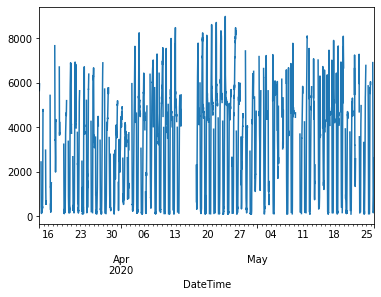

In [ ]:
dados_SPEC_valid_1['Value'].plot()

In [ ]:
dados_SPEC_valid_1['IsNaN'] = dados_SPEC_valid_1['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_SPEC_valid_1[~dados_SPEC_valid_1['IsNaN']])
nan_count   = len(dados_SPEC_valid_1[ dados_SPEC_valid_1['IsNaN']])
tot_count   = len(dados_SPEC_valid_1)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 3699, NaN: 3378, Total: 7077
Valid: 52, NaN: 47


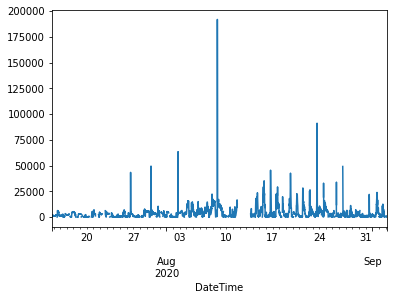

In [ ]:
dados_SPEC_valid_2['Value'].plot()

In [ ]:
dados_SPEC_valid_2['IsNaN'] = dados_SPEC_valid_2['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_SPEC_valid_2[~dados_SPEC_valid_2['IsNaN']])
nan_count   = len(dados_SPEC_valid_2[ dados_SPEC_valid_2['IsNaN']])
tot_count   = len(dados_SPEC_valid_2)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 3820, NaN: 1020, Total: 4840
Valid: 78, NaN: 21


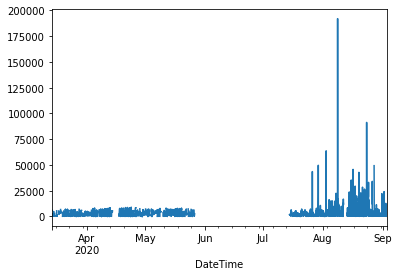

In [ ]:
dados_SPEC_valid = (pd.concat([dados_SPEC_valid_1, dados_SPEC_valid_2]).dropna()
              .resample('15T').mean())
dados_SPEC_valid['Value'].plot()

In [ ]:
dados_SPEC_valid['IsNaN'] = dados_SPEC_valid['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_SPEC_valid[~dados_SPEC_valid['IsNaN']])
nan_count   = len(dados_SPEC_valid[ dados_SPEC_valid['IsNaN']])
tot_count   = len(dados_SPEC_valid)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 7501, NaN: 9122, Total: 16623
Valid: 45, NaN: 54


#### Converte a mg/m3

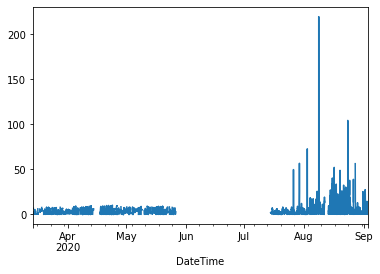

In [ ]:
M_CO = 28.01
dados_SPEC_valid_1['Value'] = dados_SPEC_valid_1['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)
dados_SPEC_valid_2['Value'] = dados_SPEC_valid_2['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)    
dados_SPEC_valid['Value'] = dados_SPEC_valid['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)
dados_SPEC_valid['Value'].plot()

### Manipulação dos dados Alphasense

#### Acrescenta valores de RH e suas etiquetas

In [ ]:
dados_Alpha_1['RH SPEC'] = dados_RH_SPEC_1.loc[dados_Alpha_1.index]['Value']
dados_Alpha_1['RH Tag'] = dados_RH_SPEC_1.loc[dados_Alpha_1.index]['Tag']
dados_Alpha_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag
DateTime,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,39.0,4.0,40.0,0.0,575.46,84.33,VALID
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,40.0,4.0,40.0,0.0,597.15,84.33,VALID
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,41.0,4.0,40.0,0.0,603.74,85.00,VALID
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,42.0,4.0,40.0,0.0,606.29,84.50,VALID
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,45.0,4.0,40.0,0.0,552.08,82.33,VALID


In [ ]:
dados_Alpha_2['RH SPEC'] = dados_RH_SPEC_2.loc[dados_Alpha_2[1:].index]['Value']
dados_Alpha_2['RH Tag'] = dados_RH_SPEC_2.loc[dados_Alpha_2[1:].index]['Tag']
dados_Alpha_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag
DateTime,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,21.0,4.0,0.0,40.0,0.000,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,22.0,4.0,0.0,40.0,1245.865,63.00,STABILZ
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,23.0,4.0,0.0,40.0,851.550,67.75,STABILZ
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,23.5,4.0,0.0,40.0,546.470,67.67,STABILZ
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING


#### Etiqueta dados de Monóxido de Carbono Alphasense

,#,%
STABILZ,2620,7.48251
VALID,32395,92.5175
TOTAL,35015,100


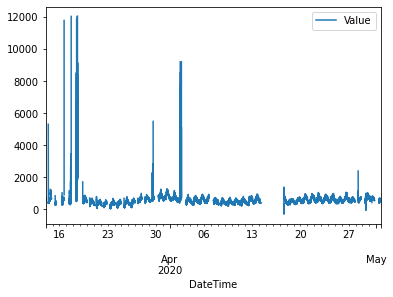

In [ ]:
# Remove outlier das 07H00
dados_Alpha_1['Tag'] = dados_Alpha_1['Hour'].map(
    lambda h: 'STABILZ' if (h >= 6 and h <= 8) else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_Alpha_1)

(dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
STABILZ,133,0.363835
VALID,36422,99.6362
TOTAL,36555,100


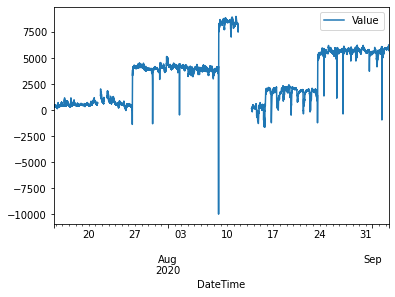

In [ ]:
# Remove outlier das 07H00
dados_Alpha_2['Tag'] = dados_Alpha_2['DeviceSt'].map(
    lambda st: 'STABILZ' if st%2 <= 0 else 'VALID')

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_Alpha_2)

(dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,10264,29.3132
STABILZ,2620,7.48251
LTLL,3,0.00856776
GTUL,0,0
VALID,22128,63.1958
TOTAL,35015,100


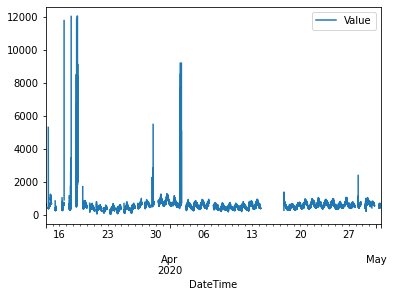

In [ ]:
dados_Alpha_1['Tag'] = dados_Alpha_1[['Value', 'Tag']].apply(
    lambda v: validate_value(v, 1e6, 4.0), axis=1)

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_Alpha_1)
(dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,2060,5.63534
STABILZ,133,0.363835
LTLL,609,1.66598
GTUL,0,0
VALID,33753,92.3348
TOTAL,36555,100


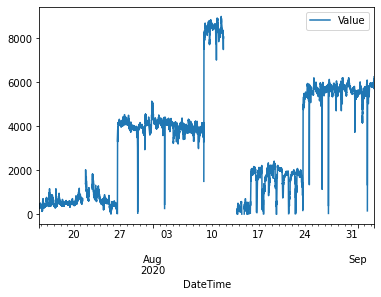

In [ ]:
dados_Alpha_2['Tag'] = dados_Alpha_2[['Value', 'Tag']].apply(
    lambda v: validate_value(v, 1e6, 4.0), axis=1)

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_Alpha_2)
(dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,10264,29.3132
STABILZ,2620,7.48251
LTLL,3,0.00856776
GTUL,0,0
BAD-RH,862,2.4618
VALID,21266,60.734
TOTAL,35015,100


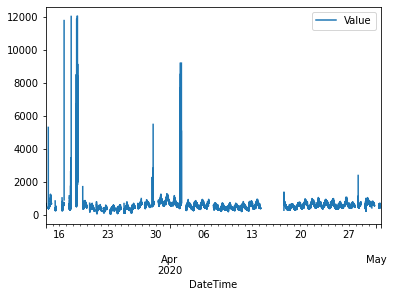

In [ ]:
dados_Alpha_1['Tag'] = (dados_Alpha_1[['Tag', 'RH Tag']]
                     .apply(lambda v: validate_with_RH(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'VALID'], 
                                  dados_Alpha_1)
(dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

,#,%
MISSING,2060,5.63534
STABILZ,133,0.363835
LTLL,609,1.66598
GTUL,0,0
BAD-RH,0,0
VALID,33753,92.3348
TOTAL,36555,100


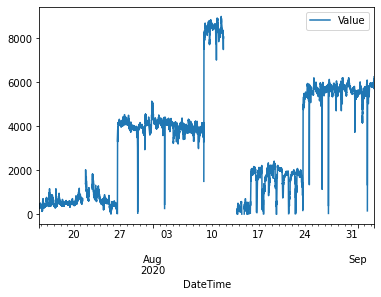

In [ ]:
dados_Alpha_2['Tag'] = (dados_Alpha_2[['Tag', 'RH Tag']]
                     .apply(lambda v: validate_with_RH(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'VALID'], 
                                  dados_Alpha_2)
(dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

#### Calcula quartís por hora Alphasense 1

In [ ]:
qtle_01 = (dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.01, interpolation='lower'))
qtle_99 = (dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.99, interpolation='higher'))

qtle_01 = qtle_01.resample('2T').pad()
qtle_99 = qtle_99.resample('2T').pad()
dados_Alpha_1['QTLE01'] = qtle_01[qtle_01.index >= dados_Alpha_1.index[0]]
dados_Alpha_1['QTLE99'] = qtle_99[qtle_99.index >= dados_Alpha_1.index[0]]
dados_Alpha_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99
DateTime,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,39.0,4.0,40.0,0.0,575.46,84.33,VALID,VALID,550.59,684.73
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,40.0,4.0,40.0,0.0,597.15,84.33,VALID,VALID,550.59,684.73
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,41.0,4.0,40.0,0.0,603.74,85.00,VALID,VALID,550.59,684.73
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,42.0,4.0,40.0,0.0,606.29,84.50,VALID,VALID,550.59,684.73
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,45.0,4.0,40.0,0.0,552.08,82.33,VALID,VALID,550.59,684.73


#### Conta dados por hora

In [ ]:
valid_hr_count = (dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID']['Value']
           .resample('1H').count()) # 1 hour / 2 min = 30 samples
dados_Alpha_1['VALID_HR_COUNT'] = valid_hr_count.resample('2T').pad() >= 23
                                    # 1 hour / 2 min = 30 samples
                                    # 22.5 = 75% of 30
dados_Alpha_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT
DateTime,,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,39.0,4.0,40.0,0.0,575.46,84.33,VALID,VALID,550.59,684.73,True
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,40.0,4.0,40.0,0.0,597.15,84.33,VALID,VALID,550.59,684.73,True
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,41.0,4.0,40.0,0.0,603.74,85.00,VALID,VALID,550.59,684.73,True
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,42.0,4.0,40.0,0.0,606.29,84.50,VALID,VALID,550.59,684.73,True
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,45.0,4.0,40.0,0.0,552.08,82.33,VALID,VALID,550.59,684.73,True


#### Calcula quartís por hora para todo o período

In [ ]:
global_qtle_01 = dados_Alpha_1.pivot(columns='Hour')['Value'].quantile(
    q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dados_Alpha_1.pivot(columns='Hour')['Value'].quantile(
    q=0.99, axis='index', interpolation='higher').dropna()

dados_Alpha_1['GLOBAL QTLE01'] = dados_Alpha_1['Hour'].map(
    lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dados_Alpha_1['GLOBAL QTLE99'] = dados_Alpha_1['Hour'].map(
    lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)

dados_Alpha_1.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,0.0,39.0,4.0,40.0,0.0,575.46,84.33,VALID,VALID,550.59,684.73,True,270.4,738.51
2020-03-14 00:02:00,2020.0,3.0,14.0,0.0,2.0,40.0,4.0,40.0,0.0,597.15,84.33,VALID,VALID,550.59,684.73,True,270.4,738.51
2020-03-14 00:04:00,2020.0,3.0,14.0,0.0,4.0,41.0,4.0,40.0,0.0,603.74,85.00,VALID,VALID,550.59,684.73,True,270.4,738.51
2020-03-14 00:06:00,2020.0,3.0,14.0,0.0,6.0,42.0,4.0,40.0,0.0,606.29,84.50,VALID,VALID,550.59,684.73,True,270.4,738.51
2020-03-14 00:08:00,2020.0,3.0,14.0,0.0,8.0,45.0,4.0,40.0,0.0,552.08,82.33,VALID,VALID,550.59,684.73,True,270.4,738.51


#### Etiqueta dados por quartís

In [ ]:
dados_Alpha_1['Tag'] = (dados_Alpha_1[['Value','Tag','QTLE01','QTLE99',
                                         'VALID_HR_COUNT', 'GLOBAL QTLE01',
                                         'GLOBAL QTLE99']]
                     .apply(lambda v: validate_with_qtle(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'LTQTLE01', 'GTQTLE99',
                                   'VALID'], dados_Alpha_1)

dados_Alpha_valid_1 = (dados_Alpha_1[dados_Alpha_1['Tag'] == 'VALID']
                        .resample('15T').mean()).copy()
data_contabilization

,#,%
MISSING,10264,29.3132
STABILZ,2620,7.48251
LTLL,3,0.00856776
GTUL,0,0
BAD-RH,862,2.4618
LTQTLE01,813,2.32186
GTQTLE99,811,2.31615
VALID,19642,56.096
TOTAL,35015,100


#### Calcula quartís por hora Alphasense 2

In [ ]:
qtle_01 = (dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.01, interpolation='lower'))
qtle_99 = (dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID']['Value']
           .resample('1H').quantile(0.99, interpolation='higher'))

qtle_01 = qtle_01.resample('2T').pad()
qtle_99 = qtle_99.resample('2T').pad()
dados_Alpha_2['QTLE01'] = qtle_01[qtle_01.index >= dados_Alpha_2.index[0]]
dados_Alpha_2['QTLE99'] = qtle_99[qtle_99.index >= dados_Alpha_2.index[0]]
dados_Alpha_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99
DateTime,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,21.0,4.0,0.0,40.0,0.000,NaN,NaN,STABILZ,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,22.0,4.0,0.0,40.0,1245.865,63.00,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,23.0,4.0,0.0,40.0,851.550,67.75,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,23.5,4.0,0.0,40.0,546.470,67.67,STABILZ,STABILZ,NaN,NaN
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN


#### Conta dados por hora

In [ ]:
valid_hr_count = (dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID']['Value']
           .resample('1H').count()) # 1 hour / 2 min = 30 samples
dados_Alpha_2['VALID_HR_COUNT'] = valid_hr_count.resample('2T').pad() >= 23
                                    # 1 hour / 2 min = 30 samples
                                    # 22.5 = 75% of 30
dados_Alpha_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT
DateTime,,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,21.0,4.0,0.0,40.0,0.000,NaN,NaN,STABILZ,NaN,NaN,NaN
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,22.0,4.0,0.0,40.0,1245.865,63.00,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,23.0,4.0,0.0,40.0,851.550,67.75,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,23.5,4.0,0.0,40.0,546.470,67.67,STABILZ,STABILZ,NaN,NaN,NaN
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN,NaN


#### Calcula quartís por hora para todo o período

In [ ]:
global_qtle_01 = dados_Alpha_2.pivot(columns='Hour')['Value'].quantile(
    q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dados_Alpha_2.pivot(columns='Hour')['Value'].quantile(
    q=0.99, axis='index', interpolation='higher').dropna()

dados_Alpha_2['GLOBAL QTLE01'] = dados_Alpha_2['Hour'].map(
    lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dados_Alpha_2['GLOBAL QTLE99'] = dados_Alpha_2['Hour'].map(
    lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)

dados_Alpha_2.head()

,Year,Month,Day,Hour,Minute,Second,Device,DeviceSt,SensorID,Value,RH SPEC,RH Tag,Tag,QTLE01,QTLE99,VALID_HR_COUNT,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,,,,,,,
2020-07-14 17:14:00,2020.0,7.0,14.0,17.0,15.0,21.0,4.0,0.0,40.0,0.000,NaN,NaN,STABILZ,NaN,NaN,NaN,-962.84,8774.23
2020-07-14 17:16:00,2020.0,7.0,14.0,17.0,16.5,22.0,4.0,0.0,40.0,1245.865,63.00,STABILZ,STABILZ,NaN,NaN,NaN,-962.84,8774.23
2020-07-14 17:18:00,2020.0,7.0,14.0,17.0,18.5,23.0,4.0,0.0,40.0,851.550,67.75,STABILZ,STABILZ,NaN,NaN,NaN,-962.84,8774.23
2020-07-14 17:20:00,2020.0,7.0,14.0,17.0,20.5,23.5,4.0,0.0,40.0,546.470,67.67,STABILZ,STABILZ,NaN,NaN,NaN,-962.84,8774.23
2020-07-14 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSING,MISSING,NaN,NaN,NaN,NaN,NaN


#### Etiqueta dados por quartís

In [ ]:
dados_Alpha_2['Tag'] = (dados_Alpha_2[['Value','Tag','QTLE01','QTLE99',
                                         'VALID_HR_COUNT', 'GLOBAL QTLE01',
                                         'GLOBAL QTLE99']]
                     .apply(lambda v: validate_with_qtle(v), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'BAD-RH', 'LTQTLE01', 'GTQTLE99',
                                   'VALID'], dados_Alpha_2)

dados_Alpha_valid_2 = (dados_Alpha_2[dados_Alpha_2['Tag'] == 'VALID']
                        .resample('15T').mean()).copy()
data_contabilization

,#,%
MISSING,2060,5.63534
STABILZ,133,0.363835
LTLL,609,1.66598
GTUL,0,0
BAD-RH,0,0
LTQTLE01,1160,3.1733
GTQTLE99,1149,3.14321
VALID,31444,86.0183
TOTAL,36555,100


#### Plota séries temporais de monóxido de carbono Alphasense

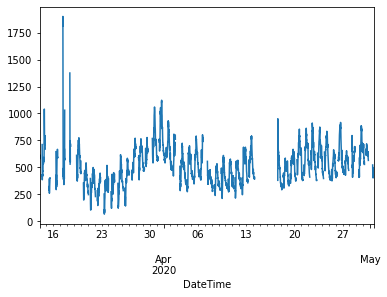

In [ ]:
dados_Alpha_valid_1['Value'].plot()

In [ ]:
dados_Alpha_valid_1['IsNaN'] = dados_Alpha_valid_1['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_Alpha_valid_1[~dados_Alpha_valid_1['IsNaN']])
nan_count   = len(dados_Alpha_valid_1[ dados_Alpha_valid_1['IsNaN']])
tot_count   = len(dados_Alpha_valid_1)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 2999, NaN: 1670, Total: 4669
Valid: 64, NaN: 35


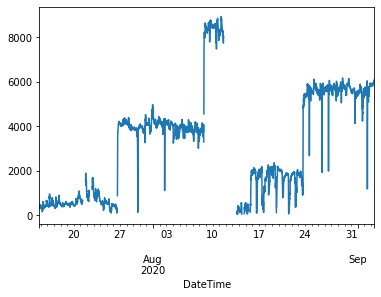

In [ ]:
dados_Alpha_valid_2['Value'].plot()

In [ ]:
dados_Alpha_valid_2['IsNaN'] = dados_Alpha_valid_2['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_Alpha_valid_2[~dados_Alpha_valid_2['IsNaN']])
nan_count   = len(dados_Alpha_valid_2[ dados_Alpha_valid_2['IsNaN']])
tot_count   = len(dados_Alpha_valid_2)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 4517, NaN: 349, Total: 4866
Valid: 92, NaN: 7


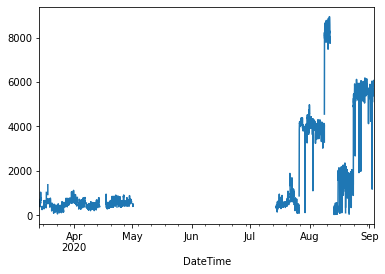

In [ ]:
dados_Alpha_valid = (pd.concat([dados_Alpha_valid_1, dados_Alpha_valid_2]).dropna()
              .resample('15T').mean())
dados_Alpha_valid['Value'].plot()

In [ ]:
dados_Alpha_valid['IsNaN'] = dados_Alpha_valid['Value'].map(
    lambda v: np.isnan(v))

valid_count = len(dados_Alpha_valid[~dados_Alpha_valid['IsNaN']])
nan_count   = len(dados_Alpha_valid[ dados_Alpha_valid['IsNaN']])
tot_count   = len(dados_Alpha_valid)
print('Valid: %d, NaN: %d, Total: %d' % (valid_count, nan_count, 
                                         tot_count))
print('Valid: %d, NaN: %d' % (valid_count/tot_count*100,
                              nan_count/tot_count*100))

Valid: 7506, NaN: 9147, Total: 16653
Valid: 45, NaN: 54


#### Converte a mg/m3

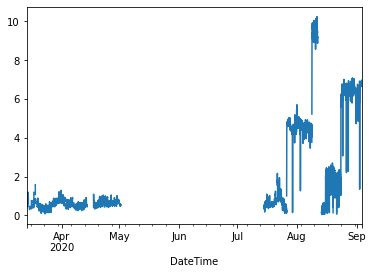

In [ ]:
M_CO = 28.01
dados_Alpha_valid_1['Value'] = dados_Alpha_valid_1['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)
dados_Alpha_valid_2['Value'] = dados_Alpha_valid_2['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)    
dados_Alpha_valid['Value'] = dados_Alpha_valid['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)
dados_Alpha_valid['Value'].plot()

### Gráficos e séries temporais

In [ ]:
dados_SPEC_valid_1.to_csv(dataFolder1.joinpath('SPEC_CO_valid.csv'))
dados_Alpha_valid_1.to_csv(dataFolder1.joinpath('ALPHA_CO_valid.csv'))

#### Plota Valid de SPEC e Alphasense

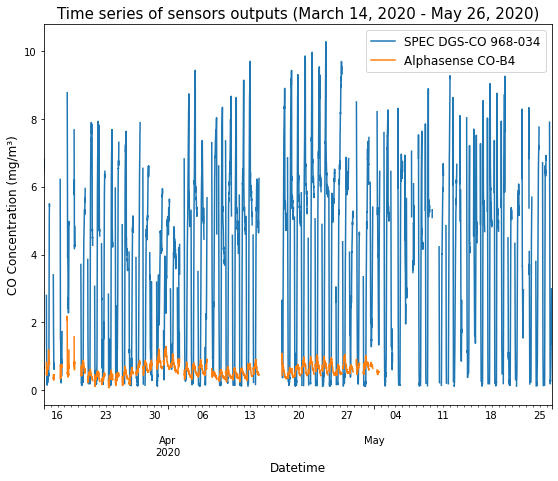

In [ ]:
dados_SPEC_valid_1['Value'].plot(figsize=(7*1.3,7))
dados_Alpha_valid_1['Value'].plot()
plt.title('Time series of sensors outputs (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', fontsize=12)

plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

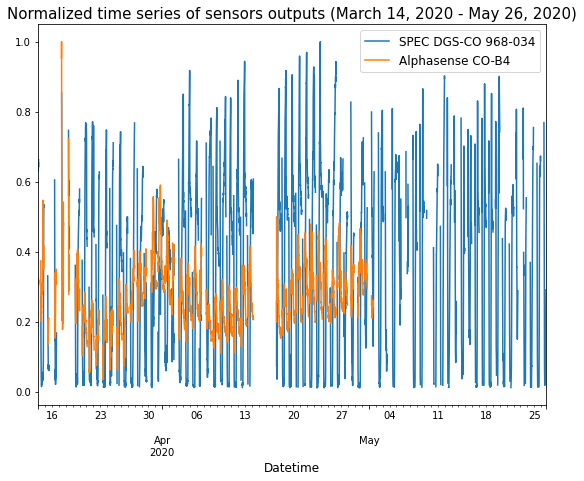

In [ ]:
dados_SPEC_valid_1['Value'].map(
    lambda v: v/dados_SPEC_valid_1['Value'].max()).plot(figsize=(7*1.3,7))
dados_Alpha_valid_1['Value'].map(
    lambda v: v/dados_Alpha_valid_1['Value'].max()).plot(figsize=(7*1.3,7))
plt.title('Normalized time series of sensors outputs (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
#plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', fontsize=12)

plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

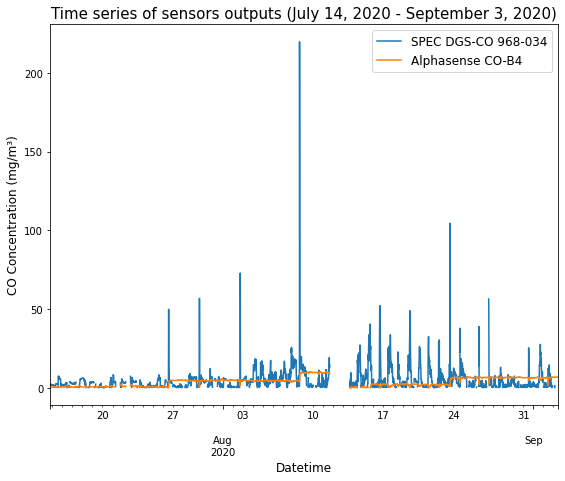

In [ ]:
dados_SPEC_valid_2['Value'].plot(figsize=(7*1.3,7))
dados_Alpha_valid_2['Value'].plot()
plt.title('Time series of sensors outputs (July 14, 2020 - September 3, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', fontsize=12)
plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

In [ ]:
dados_SPEC_valid_2['Value'].map(
    lambda v: v/dados_SPEC_valid_2['Value'].max()).plot(figsize=(7*1.3,7))
dados_Alpha_valid_2['Value'].map(
    lambda v: v/dados_Alpha_valid_2['Value'].max()).plot(figsize=(7*1.3,7))
plt.title('Normalized time series of sensors outputs (July 14, 2020 - September 3, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
#plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', fontsize=12)
plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

#### Comportamento médio diário e distribuição dos dados de CO

##### Intervalo 1 SPEC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


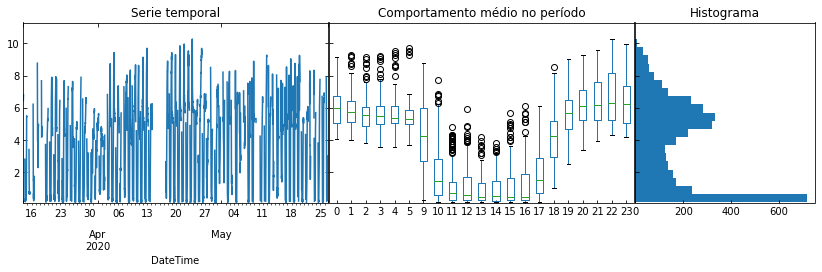

In [ ]:
plot_box_hist(dados_SPEC_valid_1.resample('15T').mean(), 20)

In [ ]:
df = dados_SPEC_valid_1.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Value'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration (ppb) measured by SPEC DGS-CO 968-03 (14/03 - 14/04)')

##### Intervalo 2 SPEC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


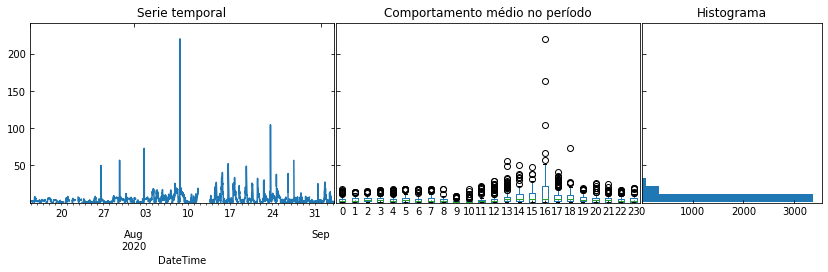

In [ ]:
plot_box_hist(dados_SPEC_valid_2.resample('15T').mean(), 20)

In [ ]:
df = dados_SPEC_valid_2.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Value'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration (ppb) measured by SPEC DGS-CO 968-03 (18/04 - 01/05)')

##### Intervalo 1 Alphasense

In [ ]:
plot_box_hist(dados_Alpha_valid_1.resample('15T').mean(), 20)

NameError: ignored

In [ ]:
df = dados_Alpha_valid_1.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Value'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration (ppb) measured by Alphasense CO-B4 (14/03 - 14/04)')

##### Intervalo 2 Alphasense

In [ ]:
plot_box_hist(dados_Alpha_valid_2.resample('15T').mean(), 20)

In [ ]:
df = dados_Alpha_valid_2.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Value'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration (ppb) measured by Alphasense CO-B4 (18/04 - 01/05)')

#### Comportamento médio diário e distribuição dos dados de umidade relativa

##### Intervalo 1

In [ ]:
df = pd.DataFrame(columns=['Value', 'Hour'])
df['Value'] = dados_SPEC_valid_1['RH SPEC']
df['Hour'] = dados_SPEC_valid_1['Hour']
plot_box_hist(df.resample('15T').mean(), 20)

In [ ]:
df = dados_SPEC_valid_1.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['RH SPEC'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of relative humidity (14/03 - 14/04)')

##### Intervalo 2

In [ ]:
df = pd.DataFrame(columns=['Value', 'Hour'])
df['Value'] = dados_SPEC_valid_2['RH SPEC']
df['Hour'] = dados_SPEC_valid_2['Hour']
plot_box_hist(df.resample('15T').mean(), 20)

In [ ]:
df = dados_SPEC_valid_2.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['RH SPEC'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of relative humidity (18/04 - 01/05)')

No gráfico do comportamento diário da umidade é possível reconhecer 5 grupos:
1. Madrugada [00h00 - 06h00): a média da umidade relativa permanece constante entre 70 % e 75 %
2. Manhã [09h00 - 12h00): a média da umidade relativa decresce de 70 % até 50 %
3. Tarde [12h00 - 17h00): a média da umidade relativa permanece constante entre 45 % e 50 %
4. Anoitecer [17h00 - 20h00): a média da umidade relativa cresce de 50 % até 60 %
5. Noite [20h00 - 24h00): a média da umidade relativa permanece aproximadamente constante entre 60 % e 65 %

#### Comportamento médio diário, todas as variáveis

##### Intervalo 1 SPEC e umidade


In [ ]:
dados_SPEC_valid_1['Sensor'] = dados_SPEC_valid_1.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_SPEC_valid_1['Norm Value'] = dados_SPEC_valid_1['Value'].map(
    lambda v: v/dados_SPEC_valid_1['Value'].max())

dados_rh = pd.DataFrame(columns=['Hour', 'Value'])
dados_rh['Hour'] = dados_SPEC_valid_1['Hour'].dropna(
    axis='index', how='any')
dados_rh['Value'] = dados_SPEC_valid_1['RH SPEC'].dropna(
    axis='index', how='any')
dados_rh['Sensor'] = dados_rh.index.map(
    lambda i: 'Relative Humidity')
dados_boxplot = pd.DataFrame(columns=['Hour', 'Sensor', 'Norm Value'])
dados_boxplot = pd.concat([dados_SPEC_valid_1[['Hour', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any')])
dados_boxplot

,Hour,Sensor,Norm Value
DateTime,,,
2020-03-14 00:00:00,0.0,SPEC DGS-CO 968-034,0.629111
2020-03-14 00:15:00,0.0,SPEC DGS-CO 968-034,0.635188
2020-03-14 00:30:00,0.0,SPEC DGS-CO 968-034,0.655717
2020-03-14 00:45:00,0.0,SPEC DGS-CO 968-034,0.641817
2020-03-14 01:00:00,1.0,SPEC DGS-CO 968-034,0.662700
...,...,...,...
2020-05-26 16:00:00,16.0,SPEC DGS-CO 968-034,0.138226
2020-05-26 16:15:00,16.0,SPEC DGS-CO 968-034,0.140734
2020-05-26 16:30:00,16.0,SPEC DGS-CO 968-034,0.178248


[Text(0, 0.5, ''), Text(0.5, 0, 'Hour')]

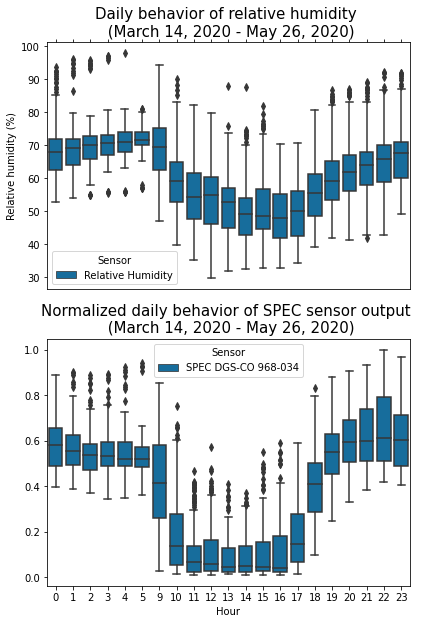

In [ ]:
dados_boxplot['Hour'] = dados_boxplot['Hour'].astype('int64')
dados_rh['Hour'] = dados_rh['Hour'].astype('int64')
fig, ax = plt.subplots(nrows=2, figsize=(1.3*5,2*5))

sns.boxplot(y='Value', x='Hour', data=dados_rh, palette="colorblind",
                 hue='Sensor', ax=ax[0])
sns.boxplot(y='Norm Value', x='Hour', data=dados_boxplot, palette="colorblind",
                 hue='Sensor', ax=ax[1])
sns.axes_style()
ax[0].set_title('Daily behavior of relative humidity \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
ax[0].set(xlabel='', ylabel='Relative humidity (%)')
ax[0].tick_params(axis='x', which='major', bottom=False, 
                  top=True, labelbottom=False)
ax[1].set_title('Normalized daily behavior of SPEC sensor output \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
ax[1].set(xlabel='Hour', ylabel='')

##### Intervalo 1

In [ ]:
dados_SPEC_valid_1['Sensor'] = dados_SPEC_valid_1.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Alpha_valid_1['Sensor'] = dados_Alpha_valid_1.index.map(
    lambda i: 'Alphasense CO-B4')
dados_SPEC_valid_1['Norm Value'] = dados_SPEC_valid_1['Value'].map(
    lambda v: v/dados_SPEC_valid_1['Value'].max())
dados_Alpha_valid_1['Norm Value'] = dados_Alpha_valid_1['Value'].map(
    lambda v: v/dados_Alpha_valid_1['Value'].max())

dados_rh = pd.DataFrame(columns=['Hour', 'Value'])
dados_rh['Hour'] = dados_SPEC_valid_1['Hour'].dropna(
    axis='index', how='any')
dados_rh['Value'] = dados_SPEC_valid_1['RH SPEC'].dropna(
    axis='index', how='any')
dados_rh['Sensor'] = dados_rh.index.map(
    lambda i: 'Relative Humidity')
dados_boxplot = pd.DataFrame(columns=['Hour', 'Sensor', 'Norm Value'])
#dados_boxplot = pd.DataFrame(columns=['Hour', 'Sensor', 'Value'])
dados_boxplot = pd.concat([dados_SPEC_valid_1[['Hour', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any'),
                           dados_Alpha_valid_1[['Hour', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any')])
#dados_boxplot = pd.concat([dados_SPEC_valid_1[['Hour', 'Sensor', 'Value']]
#                           .dropna(axis='index', how='any'),
#                           dados_Alpha_valid_1[['Hour', 'Sensor', 'Value']]
#                           .dropna(axis='index', how='any')])
dados_boxplot

,Hour,Sensor,Norm Value
DateTime,,,
2020-03-14 00:00:00,0.0,SPEC DGS-CO 968-034,0.629111
2020-03-14 00:15:00,0.0,SPEC DGS-CO 968-034,0.635188
2020-03-14 00:30:00,0.0,SPEC DGS-CO 968-034,0.655717
2020-03-14 00:45:00,0.0,SPEC DGS-CO 968-034,0.641817
2020-03-14 01:00:00,1.0,SPEC DGS-CO 968-034,0.662700
...,...,...,...
2020-05-01 14:00:00,14.0,Alphasense CO-B4,0.249749
2020-05-01 14:15:00,14.0,Alphasense CO-B4,0.247261
2020-05-01 14:30:00,14.0,Alphasense CO-B4,0.251635


[Text(0, 0.5, ''), Text(0.5, 0, 'Hour')]

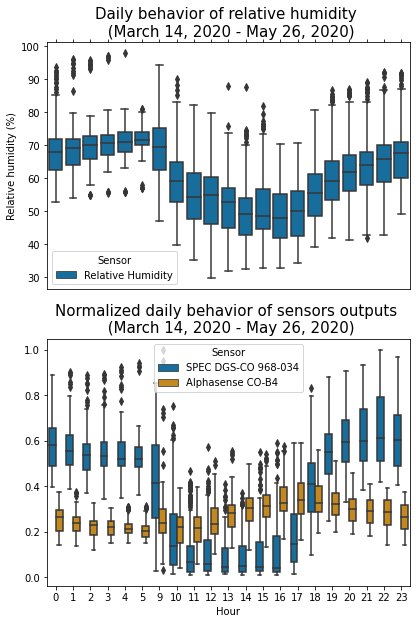

In [ ]:
dados_boxplot['Hour'] = dados_boxplot['Hour'].astype('int64')
dados_rh['Hour'] = dados_rh['Hour'].astype('int64')
fig, ax = plt.subplots(nrows=2, figsize=(1.3*5,2*5))

sns.boxplot(y='Value', x='Hour', data=dados_rh, palette="colorblind",
                 hue='Sensor', ax=ax[0])
sns.boxplot(y='Norm Value', x='Hour', data=dados_boxplot, palette="colorblind",
                 hue='Sensor', ax=ax[1])
sns.axes_style()
ax[0].set_title('Daily behavior of relative humidity \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
ax[0].set(xlabel='', ylabel='Relative humidity (%)')
ax[0].tick_params(axis='x', which='major', bottom=False, 
                  top=True, labelbottom=False)
ax[1].set_title('Normalized daily behavior of sensors outputs \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
ax[1].set(xlabel='Hour', ylabel='')
#plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
#           fontsize=12, ax=ax[1])

#plt.title('Box-Whisker plots of sensor outputs and relative humidity \n daily behaviors (March 14, 2020 - May 26, 2020)', 
#          fontdict={'fontsize':15})
#plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
#           prop={'size': 12})

##### Intervalo 2

In [ ]:
dados_SPEC_valid_2['Sensor'] = dados_SPEC_valid_2.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Alpha_valid_2['Sensor'] = dados_Alpha_valid_2.index.map(
    lambda i: 'Alphasense CO-B4')

dados_rh = pd.DataFrame(columns=['Hour', 'Value'])
dados_rh['Hour'] = dados_SPEC_valid_2['Hour'].dropna(
    axis='index', how='any')
dados_rh['Value'] = dados_SPEC_valid_2['RH SPEC'].dropna(
    axis='index', how='any')
dados_rh['Sensor'] = dados_rh.index.map(
    lambda i: 'Relative Humidity')
dados_boxplot = pd.DataFrame(columns=['Hour', 'Sensor', 'Value'])
dados_boxplot = pd.concat([dados_SPEC_valid_2[['Hour', 'Sensor', 'Value']]
                           .dropna(axis='index', how='any'),
                           dados_Alpha_valid_2[['Hour', 'Sensor', 'Value']]
                           .dropna(axis='index', how='any')])
dados_boxplot

In [ ]:
dados_boxplot['Hour'] = dados_boxplot['Hour'].astype('int64')
dados_rh['Hour'] = dados_rh['Hour'].astype('int64')
dados_boxplot['Value'] = dados_boxplot['Value'].map(lambda v: np.log10(v))
fig, ax = plt.subplots(nrows=2, figsize=(1.3*7,7))
sns.boxplot(y='Value', x='Hour', data=dados_rh, palette="colorblind",
                 hue='Sensor', ax=ax[0])
sns.boxplot(y='Value', x='Hour', data=dados_boxplot, palette="colorblind",
                 hue='Sensor', ax=ax[1])

## Análise dos dados

#### Plota Intervalo 1 SPEC vs Umidade relativa

Spearmans correlation coefficient: 0.528
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.528
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, "Kendall's tau=0.359, p<0.05")

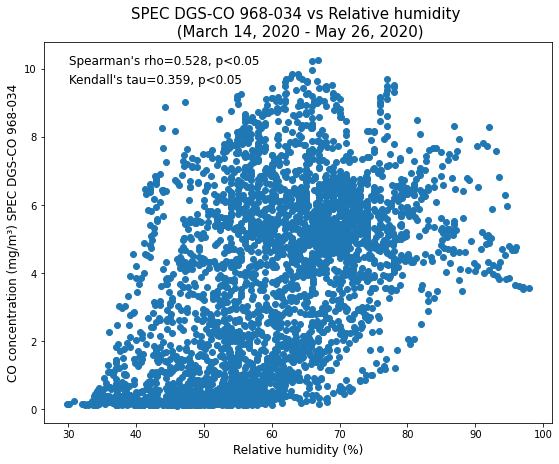

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_valid_1['RH SPEC'], dados_SPEC_valid_1['Value'])
plt.title('SPEC DGS-CO 968-034 vs Relative humidity \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Relative humidity (%)', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) SPEC DGS-CO 968-034', 
           fontsize=12)
coef, p = spearmanr(dados_SPEC_valid_1['RH SPEC'], 
                    dados_SPEC_valid_1['Value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_valid_1['RH SPEC'], 
                    dados_SPEC_valid_1['Value'], 
                    nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

#### Plota Intervalo 2 SPEC vs Umidade relativa

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_valid_2['Value'], dados_SPEC_valid_2['RH SPEC'])

coef, p = spearmanr(dados_SPEC_valid_2['Value'], 
                    dados_SPEC_valid_2['RH SPEC'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_valid_2['Value'], 
                    dados_SPEC_valid_2['RH SPEC'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.5, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.5, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) measured by SPEC DGS-CO 968-03 (14/07 - 03/09)')
plt.ylabel('Relative humidity (14/07 - 03/09)')

#### Plota Intervalo 1 Alphasense vs Umidade relativa

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_Alpha_valid_1['RH SPEC'], dados_Alpha_valid_1['Value'])
plt.title('Alphasense CO-B4 vs Relative humidity \n (March 14, 2020 - May 1st, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Relative humidity (%)', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) Alphasense CO-B4', 
           fontsize=12)

coef, p = spearmanr(dados_Alpha_valid_1['RH SPEC'],
                    dados_Alpha_valid_1['Value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_Alpha_valid_1['RH SPEC'],
                    dados_Alpha_valid_1['Value'],
                    nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.85, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

#### Plota Intervalo 2 Alphasense vs Umidade relativa

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_Alpha_valid_2['Value'], dados_Alpha_valid_2['RH SPEC'])

coef, p = spearmanr(dados_Alpha_valid_2['Value'], 
                    dados_Alpha_valid_2['RH SPEC'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_Alpha_valid_2['Value'], 
                    dados_Alpha_valid_2['RH SPEC'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.5, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.5, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by SPEC DGS-CO 968-03 (14/07 - 03/09)')
plt.ylabel('Relative humidity (14/07 - 03/09)')

#### Plota Intervalo 1 SPEC vs Alphasense

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_valid_1.loc[dados_Alpha_valid_1.index]['Value'], 
            dados_Alpha_valid_1['Value'])
plt.title('Alphasense CO-B4 vs. SPEC DGS-CO 968-034 \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) SPEC DGS-CO 968-03', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) Alphasense CO-B4', 
           fontsize=12)
coef, p = spearmanr(dados_SPEC_valid_1.loc[dados_Alpha_valid_1.index]['Value'],
                    dados_Alpha_valid_1['Value'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_valid_1.loc[dados_Alpha_valid_1.index]['Value'],
                    dados_Alpha_valid_1['Value'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.1, 0.9, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.1, 0.85, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

#### Plota Intervalo 2 SPEC vs Alphasense

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_valid_2['Value'],
            dados_Alpha_valid_2.loc[dados_SPEC_valid_2.index]['Value'])

coef, p = spearmanr(dados_SPEC_valid_2['Value'],
                    dados_Alpha_valid_2.loc[dados_SPEC_valid_2.index]['Value'],
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_valid_2['Value'],
                    dados_Alpha_valid_2.loc[dados_SPEC_valid_2.index]['Value'],
                    nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p=%.3f' % (coef,p)
plt.text(0.5, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p=%.3f' % (kendall,p)
plt.text(0.5, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by SPEC DGS-CO 968-03 (14/07 - 03/09)')
plt.ylabel('CO concentration (ppb) measured by Alphasense CO-B4 (14/07 - 03/09)')

In [ ]:
plt.figure(figsize=(13,10))
hb = plt.hexbin(dados_SPEC_valid_1st['Value'], 
                dados_SPEC_valid_1st['RH SPEC'], gridsize=50, bins='log')
plt.xlabel('Concentração de CO')
plt.ylabel('Umidade Relativa')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')

## Análise do comportamento da umidade por horários durante o dia

No gráfico do comportamento diário da umidade é possível reconhecer 5 grupos:
1. Madrugada [00h00 - 06h00]: a média da umidade relativa permanece constante entre 70 % e 75 %
2. Manhã [09h00 - 12h00): a média da umidade relativa decresce de 70 % até 50 %
3. Tarde [12h00 - 17h00): a média da umidade relativa permanece constante entre 45 % e 50 %
4. Anoitecer [17h00 - 20h00): a média da umidade relativa cresce de 50 % até 60 %
5. Noite [20h00 - 24h00): a média da umidade relativa permanece aproximadamente constante entre 60 % e 65 %

##### Umidade: Grupo 1

In [ ]:
umidade_gr1 = (dados_RH.where(dados_RH['Hour'].ge(0))
               .where(dados_RH['Hour'].le(6)).dropna(axis='index', how='all'))
umidade_gr1.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 1)',
    figsize=(5*1.3,5))
plot_box_hist(umidade_gr1.resample('2T').mean(), 10)

##### Umidade: Grupo 2

In [ ]:
umidade_gr2 = (dados_RH.where(dados_RH['Hour'].ge(8))
               .where(dados_RH['Hour'].lt(12)).dropna(axis='index', how='all'))
umidade_gr2.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 2)',
    figsize=(5*1.3,5))
plot_box_hist(umidade_gr2.resample('2T').mean(), 10)

##### Umidade: Grupo 3

In [ ]:
umidade_gr3 = (dados_RH.where(dados_RH['Hour'].ge(12))
               .where(dados_RH['Hour'].lt(17)).dropna(axis='index', how='all'))
umidade_gr3.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 3)',
    figsize=(5*1.3,5))
plot_box_hist(umidade_gr3.resample('2T').mean(), 10)

##### Umidade: Grupo 4

In [ ]:
umidade_gr4 = (dados_RH.where(dados_RH['Hour'].ge(17))
               .where(dados_RH['Hour'].lt(20)).dropna(axis='index', how='all'))
umidade_gr4.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 4)',
    figsize=(5*1.3,5))
plot_box_hist(umidade_gr4.resample('2T').mean(), 10)

##### Umidade: Grupo 5

In [ ]:
umidade_gr5 = (dados_RH.where(dados_RH['Hour'].ge(20))
               .where(dados_RH['Hour'].lt(24)).dropna(axis='index', how='all'))
umidade_gr5.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 5)',
    figsize=(5*1.3,5))
plot_box_hist(umidade_gr5.resample('2T').mean(), 10)

## Análise de sazonalidade

### Intervalo 1

In [ ]:
dados_SPEC_noseason_1 = dados_SPEC_valid_1.drop(
    columns=['Device','DeviceSt',' SensorID','QTLE01','QTLE99','GLOBAL QTLE01',
             'GLOBAL QTLE99']).copy()
dados_SPEC_noseason_1.head()

,Year,Month,Day,Hour,Minute,Second,Value,RH SPEC,IsNaN,Sensor,Norm Value
DateTime,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,8.142857,23.714286,6.465518,86.998571,False,SPEC DGS-CO 968-034,0.629111
2020-03-14 00:15:00,2020.0,3.0,14.0,0.0,23.000000,30.000000,6.527968,90.445000,False,SPEC DGS-CO 968-034,0.635188
2020-03-14 00:30:00,2020.0,3.0,14.0,0.0,38.000000,33.750000,6.738950,89.041250,False,SPEC DGS-CO 968-034,0.655717
2020-03-14 00:45:00,2020.0,3.0,14.0,0.0,53.666667,37.333333,6.596100,85.306667,False,SPEC DGS-CO 968-034,0.641817
2020-03-14 01:00:00,2020.0,3.0,14.0,1.0,8.000000,29.500000,6.810717,86.602500,False,SPEC DGS-CO 968-034,0.662700


In [ ]:
dados_Alpha_noseason_1 = dados_Alpha_valid_1.drop(
    columns=['Device','DeviceSt',' SensorID','QTLE01','QTLE99','GLOBAL QTLE01',
             'GLOBAL QTLE99']).copy()
dados_Alpha_noseason_1.head()

,Year,Month,Day,Hour,Minute,Second,Value,RH SPEC,IsNaN,Sensor,Norm Value
DateTime,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,6.571429,42.857143,0.676618,86.070000,False,Alphasense CO-B4,0.310563
2020-03-14 00:15:00,2020.0,3.0,14.0,0.0,22.000000,49.714286,0.706919,90.642857,False,Alphasense CO-B4,0.324471
2020-03-14 00:30:00,2020.0,3.0,14.0,0.0,37.000000,53.875000,0.701721,89.041250,False,Alphasense CO-B4,0.322085
2020-03-14 00:45:00,2020.0,3.0,14.0,0.0,53.600000,33.200000,0.671577,85.034000,False,Alphasense CO-B4,0.308249
2020-03-14 01:00:00,2020.0,3.0,14.0,1.0,7.000000,49.500000,0.696366,86.602500,False,Alphasense CO-B4,0.319627


#### Decomposição do sinal sensor SPEC

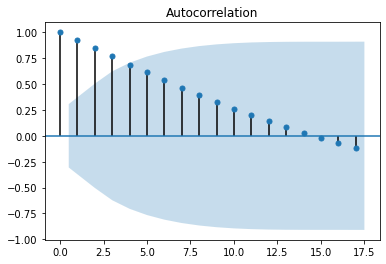

<Figure size 655.2x504 with 0 Axes>

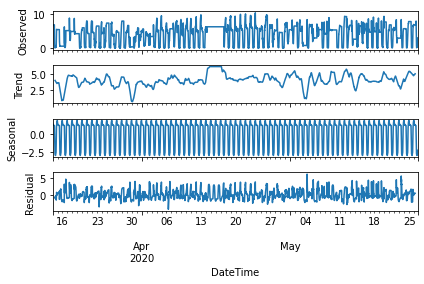

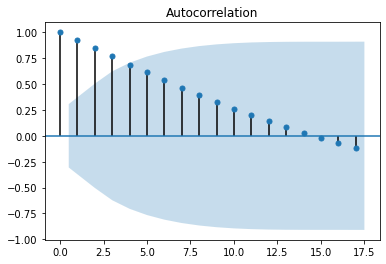

In [ ]:
signal_spec_1 = seasonal_decompose(dados_SPEC_valid_1['Value']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_spec_1.plot()
tsaplots.plot_acf(stattools.acf(signal_spec_1.resid.dropna(), nlags=40, 
             fft=False))

#### Decomposição do sinal de umidade relativa

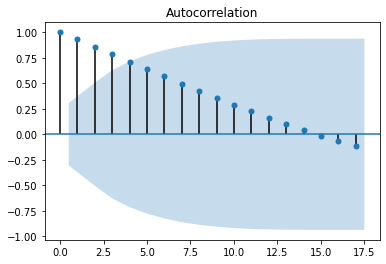

<Figure size 655.2x504 with 0 Axes>

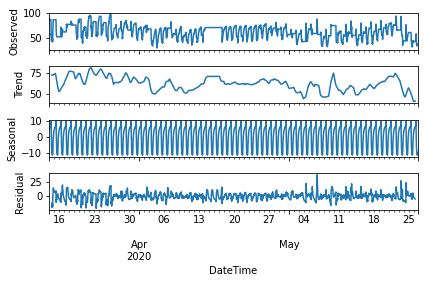

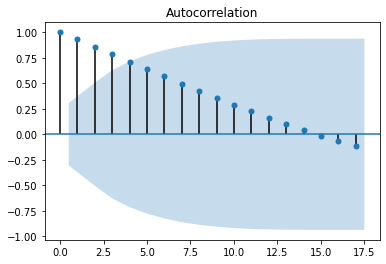

In [ ]:
signal_rh_1 = seasonal_decompose(dados_SPEC_valid_1['RH SPEC']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_rh_1.plot()
tsaplots.plot_acf(stattools.acf(signal_rh_1.resid.dropna(), nlags=40, 
             fft=False))

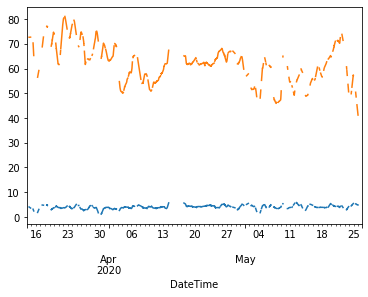

In [ ]:
def rem_nan_tag(df):  return np.nan if df[1] else df[0]

#dados_SPEC_noseason_1['Value'] = signal_spec_1.resid+signal_spec_1.trend
dados_SPEC_noseason_1['Value'] = signal_spec_1.trend
dados_SPEC_noseason_1['RH SPEC'] = signal_rh_1.trend
dados_SPEC_noseason_1['Value'] = (dados_SPEC_noseason_1[['Value', 'IsNaN']]
                                   .apply(lambda df: rem_nan_tag(df), axis=1))
dados_SPEC_noseason_1['RH SPEC'] = (dados_SPEC_noseason_1[['RH SPEC', 'IsNaN']]
                                   .apply(lambda df: rem_nan_tag(df), axis=1))

dados_SPEC_noseason_1['Value'].plot()
dados_SPEC_noseason_1['RH SPEC'].plot()

#### Comportamento diário e distribuição dos dados de concentração SPEC sem sazonalidade

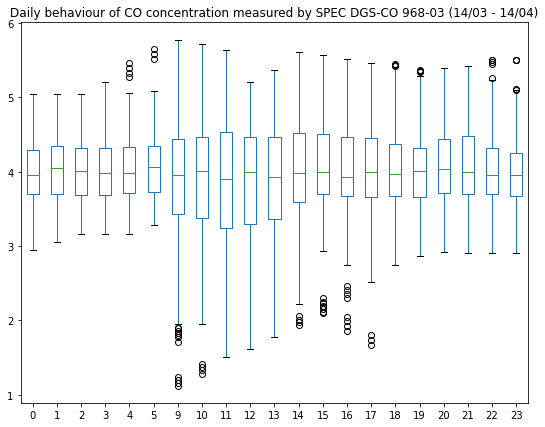

In [ ]:
df = dados_SPEC_noseason_1.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Value'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration measured by SPEC DGS-CO 968-03 (14/03 - 14/04)')

#### Decomposição do sinal sensor Alphasense

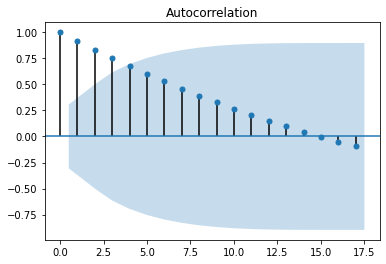

<Figure size 655.2x504 with 0 Axes>

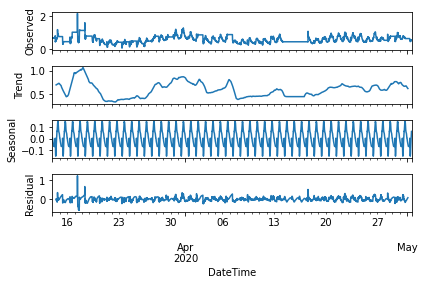

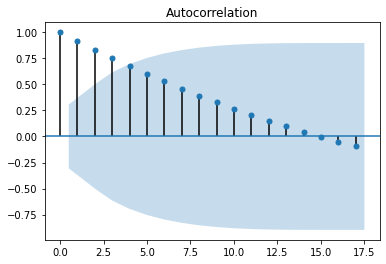

In [ ]:
signal_alpha_1 = seasonal_decompose(dados_Alpha_valid_1['Value']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_alpha_1.plot()
tsaplots.plot_acf(stattools.acf(signal_alpha_1.resid.dropna(), nlags=40, 
             fft=False))

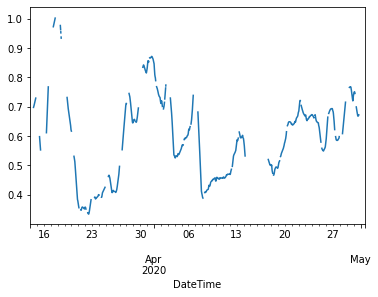

In [ ]:
def rem_nan_tag(df):  return np.nan if df[1] else df[0]

#dados_Alpha_noseason_1['Value'] = signal_alpha_1.resid+signal_alpha_1.trend
dados_Alpha_noseason_1['Value'] = signal_alpha_1.trend
dados_Alpha_noseason_1['Value'] = (dados_Alpha_noseason_1[['Value', 'IsNaN']]
                                   .apply(lambda df: rem_nan_tag(df), axis=1))

dados_Alpha_noseason_1['Value'].plot()

#### Plota série temporal de SPEC e Alphasense (trend)

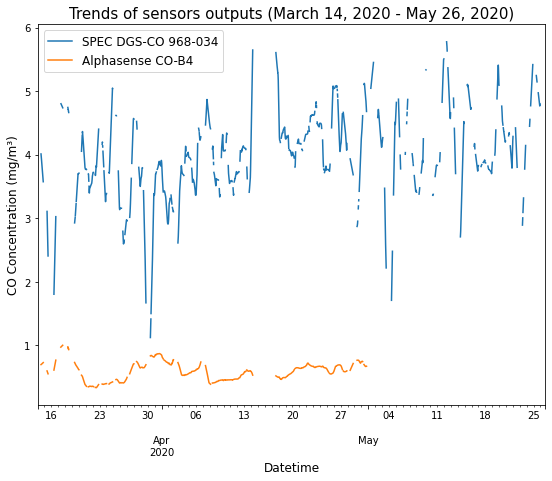

In [ ]:
dados_SPEC_noseason_1['Value'].plot(figsize=(7*1.3,7))
dados_Alpha_noseason_1['Value'].plot()
plt.title('Trends of sensors outputs (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('CO Concentration (mg/m\N{SUPERSCRIPT THREE})', fontsize=12)

plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

#### Plota série temporal de SPEC e Alphasense normalizado (trend)

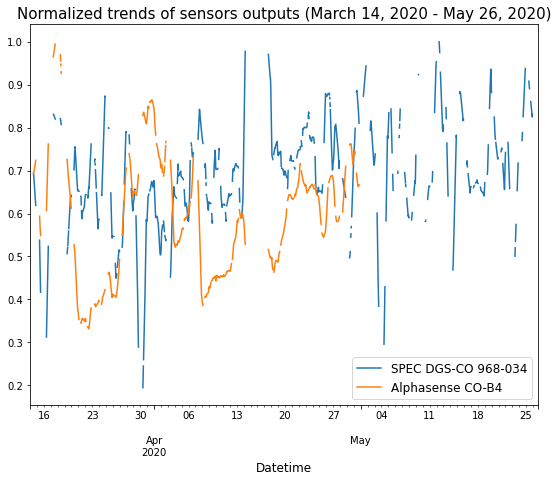

In [ ]:
dados_SPEC_noseason_1['Norm Value'] = dados_SPEC_noseason_1['Value'].map(
    lambda v: v/dados_SPEC_noseason_1['Value'].max())
dados_Alpha_noseason_1['Norm Value'] = dados_Alpha_noseason_1['Value'].map(
    lambda v: v/dados_Alpha_noseason_1['Value'].max())

dados_SPEC_noseason_1['Norm Value'].plot(figsize=(7*1.3,7))
dados_Alpha_noseason_1['Norm Value'].plot()
plt.title('Normalized trends of sensors outputs (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)

plt.legend(['SPEC DGS-CO 968-034', 'Alphasense CO-B4'], 
           prop={'size': 12})

#### Plota série temporal de SPEC e RH normalizado (trend)

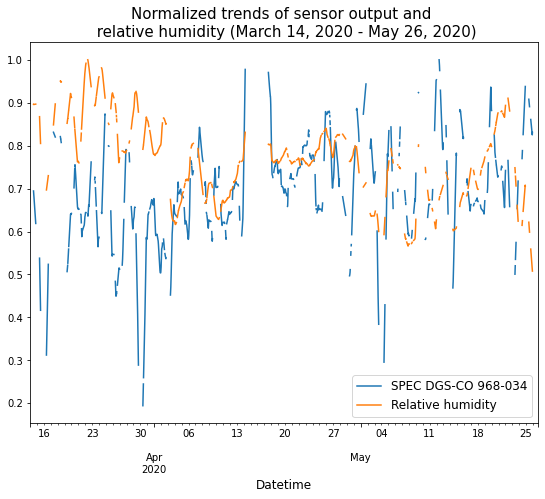

In [ ]:
norm_rh = dados_SPEC_noseason_1['RH SPEC'].map(
    lambda v: v/dados_SPEC_noseason_1['RH SPEC'].max())

dados_SPEC_noseason_1['Norm Value'].plot(figsize=(7*1.3,7))
norm_rh.plot()
plt.title('Normalized trends of sensor output and \n relative humidity (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Datetime', fontsize=12)

plt.legend(['SPEC DGS-CO 968-034', 'Relative humidity'], 
           prop={'size': 12})

#### Plota Intervalo 1 SPEC vs Alphasense (trend)

##### Pearson

In [ ]:
alpha_1hr = pd.DataFrame(columns=['Value','Datetime'])
alpha_1hr['Value'] = dados_Alpha_noseason_1.resample('1H').mean().dropna()['Value']
alpha_1hr['Datetime'] = dados_Alpha_noseason_1.resample('1H').mean().dropna().index

spec_1hr = pd.DataFrame(columns=['Value','Datetime'])
spec_1hr['Value'] = dados_SPEC_noseason_1.resample('1H').mean().dropna()['Value']
spec_1hr['Datetime'] = dados_SPEC_noseason_1.resample('1H').mean().dropna().index

dados_1hr = pd.merge_ordered(spec_1hr, alpha_1hr, 
                             on='Datetime', suffixes=('_SPEC','_Alpha'))
dados_1hr = dados_1hr.drop(columns='Datetime').dropna(how='any')
dados_1hr['Value_Alpha'].plot()
#dados_1hr.tail()
sns.pairplot(dados_1hr)

In [ ]:
from scipy.stats import kendalltau, pearsonr
r, p = pearsonr(dados_1hr['Value_Alpha'],dados_1hr['Value_SPEC'])
r
p

##### Spearman e Kendall

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_noseason_1.loc[dados_Alpha_noseason_1.index]['Value'], 
            dados_Alpha_noseason_1['Value'])
plt.title('Alphasense CO-B4 vs. SPEC DGS-CO 968-034 \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) SPEC DGS-CO 968-03', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) Alphasense CO-B4', 
           fontsize=12)
coef, p = spearmanr(dados_SPEC_noseason_1.loc[dados_Alpha_noseason_1.index]['Value'],
                    dados_Alpha_noseason_1['Value'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_noseason_1.loc[dados_Alpha_noseason_1.index]['Value'],
                    dados_Alpha_noseason_1['Value'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.1, 0.9, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.1, 0.85, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

#### Plota Intervalo 1 SPEC vs Umidade relativa (trend)

##### Pearson

In [ ]:
spec_1hr = pd.DataFrame(columns=['Value','Datetime'])
spec_1hr['Value'] = dados_SPEC_noseason_1.resample('1H').mean().dropna()['Value']
spec_1hr['Datetime'] = dados_SPEC_noseason_1.resample('1H').mean().dropna().index

rh_1hr = pd.DataFrame(columns=['Value','Datetime'])
rh_1hr['Value'] = dados_SPEC_noseason_1.resample('1H').mean().dropna()['RH SPEC']
rh_1hr['Datetime'] = dados_SPEC_noseason_1.resample('1H').mean().dropna().index

dados_1hr = pd.merge_ordered(spec_1hr, rh_1hr, 
                             on='Datetime', suffixes=('_SPEC','_RH'))
dados_1hr = dados_1hr.drop(columns='Datetime').dropna(how='any')
#dados_1hr['Value_RH'].plot()
#dados_1hr.tail()
dados_1hr.head()
sns.pairplot(dados_1hr)
#plt.scatter(dados_1hr['Value_SPEC'], 
#            dados_1hr['Value_RH'])

In [ ]:
from scipy.stats import kendalltau, pearsonr
r, p = pearsonr(dados_1hr['Value_RH'],dados_1hr['Value_SPEC'])
r
p

##### Spearman e Kendall

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_SPEC_noseason_1['RH SPEC'], dados_SPEC_noseason_1['Value'])
plt.title('SPEC DGS-CO 968-034 vs Relative humidity \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
plt.xlabel('Relative humidity (%)', 
           fontsize=12)
plt.ylabel('CO concentration (mg/m\N{SUPERSCRIPT THREE}) SPEC DGS-CO 968-034', 
           fontsize=12)
coef, p = spearmanr(dados_SPEC_noseason_1['RH SPEC'], 
                    dados_SPEC_noseason_1['Value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_SPEC_noseason_1['RH SPEC'], 
                    dados_SPEC_noseason_1['Value'], 
                    nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % kendall )
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % pken)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

#### Etiqueta por dias da semana e semanas (trends)

In [ ]:
wdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                    'Friday', 'Saturday', 'Sunday']

dados_SPEC_noseason_1['Weekday']  = dados_SPEC_noseason_1.index.map(lambda d: wdays[d.weekday()])
dados_SPEC_noseason_1.head()
dados_Alpha_noseason_1['Weekday']  = dados_Alpha_noseason_1.index.map(lambda d: wdays[d.weekday()])
dados_Alpha_noseason_1.head()

,Year,Month,Day,Hour,Minute,Second,Value,RH SPEC,IsNaN,Sensor,Norm Value,Weekday
DateTime,,,,,,,,,,,,
2020-03-14 00:00:00,2020.0,3.0,14.0,0.0,6.571429,42.857143,NaN,86.070000,False,Alphasense CO-B4,NaN,Saturday
2020-03-14 00:15:00,2020.0,3.0,14.0,0.0,22.000000,49.714286,NaN,90.642857,False,Alphasense CO-B4,NaN,Saturday
2020-03-14 00:30:00,2020.0,3.0,14.0,0.0,37.000000,53.875000,NaN,89.041250,False,Alphasense CO-B4,NaN,Saturday
2020-03-14 00:45:00,2020.0,3.0,14.0,0.0,53.600000,33.200000,NaN,85.034000,False,Alphasense CO-B4,NaN,Saturday
2020-03-14 01:00:00,2020.0,3.0,14.0,1.0,7.000000,49.500000,NaN,86.602500,False,Alphasense CO-B4,NaN,Saturday


#### Box plot por dia da semana (trends)



In [ ]:
box = dados_SPEC_noseason_1.pivot(columns='Weekday')['Value'].dropna(
      axis='columns', how='all')
box.plot.box(
        title='Comportamento médio semanal do Monóxido de Carbono no período',
        figsize=(7, 7/1.3))

In [ ]:
box = dados_Alpha_noseason_1.pivot(columns='Weekday')['Value'].dropna(
      axis='columns', how='all')
box.plot.box(
        title='Comportamento médio semanal do Monóxido de Carbono no período',
        figsize=(7, 7/1.3))

#### Comportamento médio diário, todas as variáveis (trend)

##### Intervalo 1

In [ ]:
dados_boxplot = pd.DataFrame(columns=['Weekday', 'Sensor', 'Norm Value'])
dados_boxplot = pd.concat([dados_SPEC_noseason_1[['Weekday', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any'),
                           dados_Alpha_noseason_1[['Weekday', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any')])
dados_boxplot

,Weekday,Sensor,Norm Value
DateTime,,,
2020-03-14 12:00:00,Saturday,SPEC DGS-CO 968-034,0.694515
2020-03-14 12:15:00,Saturday,SPEC DGS-CO 968-034,0.692598
2020-03-14 12:30:00,Saturday,SPEC DGS-CO 968-034,0.690433
2020-03-14 12:45:00,Saturday,SPEC DGS-CO 968-034,0.688207
2020-03-14 13:00:00,Saturday,SPEC DGS-CO 968-034,0.685917
...,...,...,...
2020-04-30 17:00:00,Thursday,Alphasense CO-B4,0.665283
2020-04-30 17:15:00,Thursday,Alphasense CO-B4,0.665726
2020-04-30 17:30:00,Thursday,Alphasense CO-B4,0.666168


[Text(0, 0.5, ''), Text(0.5, 0, '')]

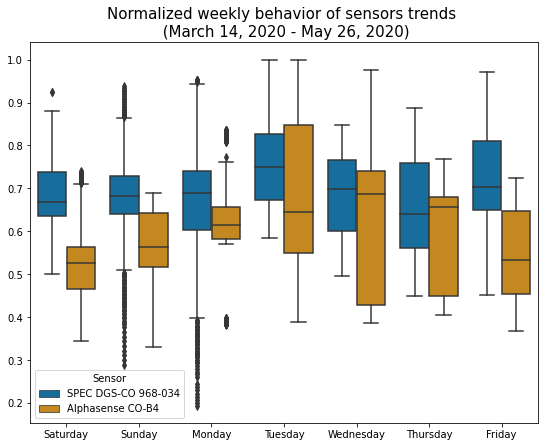

In [ ]:
fig, ax = plt.subplots(figsize=(1.3*7,7))

sns.boxplot(y='Norm Value', x='Weekday', data=dados_boxplot, 
            palette="colorblind", hue='Sensor', ax=ax)
ax.set_title('Normalized weekly behavior of sensors trends \n (March 14, 2020 - May 26, 2020)', 
          fontdict={'fontsize':15})
ax.set(xlabel='', ylabel='')

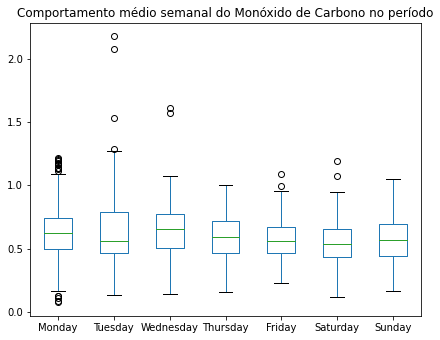

In [ ]:
dados_Alpha_valid_1['Weekday']  = dados_Alpha_valid_1.index.map(lambda d: d.weekday())
box = dados_Alpha_valid_1.pivot(columns='Weekday')['Value'].dropna(
      axis='columns', how='all')
box.columns = wdays
box.plot.box(
        title='Comportamento médio semanal do Monóxido de Carbono no período',
        figsize=(7, 7/1.3))

#### Plota Intervalo 1 Alphasense vs Umidade relativa (sem sazonalidade)

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_no_season_1st['Conc Alpha'], dados_no_season_1st['RH SPEC'])

coef, p = spearmanr(dados_no_season_1st['Conc Alpha'], 
                    dados_no_season_1st['RH SPEC'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_no_season_1st['Conc Alpha'], 
                    dados_no_season_1st['RH SPEC'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p=%.3f' % (coef, p)
plt.text(0.6, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p=%.3f' % (kendall, pken)
plt.text(0.6, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by Alphasense CO-B4 (14/03 - 14/04)')
plt.ylabel('Relative humidity (14/03 - 14/04)')

### Intervalo 2

In [ ]:
dados_no_season_2nd = dados_SPEC_valid_2nd.rename(
    columns={"Value": "Conc SPEC"}).drop(
    columns=['QTLE01','QTLE99','GLOBAL QTLE01',
             'GLOBAL QTLE99', 'IsNaN']).copy()
dados_no_season_2nd['Conc Alpha'] = dados_Alpha_valid_2nd['Value']
dados_no_season_2nd.head()

#### Decomposição do sinal umidade

In [ ]:
signal_hum_2nd = seasonal_decompose(dados_SPEC_valid_2nd['RH SPEC']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_hum_2nd.plot()
tsaplots.plot_acf(stattools.acf(signal_hum_2nd.resid.dropna(), nlags=40, 
             fft=False))

In [ ]:
dados_no_season_2nd['RH SPEC'] = signal_hum_2nd.resid+signal_hum_2nd.trend
dados_no_season_2nd['RH SPEC'].plot()

#### Comportamento diário e distribuição dos dados

In [ ]:
df = dados_no_season_1st.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['RH SPEC'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of relative humidity (14/03 - 14/04)')

In [ ]:
df = pd.DataFrame(columns=['Value', 'Hour'])
df['Value'] = dados_no_season_2nd['RH SPEC']
df['Hour'] = dados_no_season_2nd['Hour']
plot_box_hist(df.resample('15T').mean(), 20)

#### Decomposição do sinal sensor SPEC

In [ ]:
signal_spec_2nd = seasonal_decompose(dados_SPEC_valid_2nd['Value']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_spec_2nd.plot()
tsaplots.plot_acf(stattools.acf(signal_spec_2nd.resid.dropna(), nlags=40, 
             fft=False))

In [ ]:
dados_no_season_2nd['Conc SPEC'] = signal_spec_2nd.resid+signal_spec_2nd.trend
dados_no_season_2nd['Conc SPEC'].plot()

In [ ]:
dados_no_season_2nd['Conc SPEC'] = dados_no_season_2nd['Conc SPEC'].map(
    lambda v: np.nan if v <= 100.0 else v)
dados_no_season_2nd['Conc SPEC'].plot()

#### Comportamento diário e distribuição dos dados de concentração SPEC sem sazonalidade

In [ ]:
df = dados_no_season_2nd.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Conc SPEC'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration measured by SPEC DGS-CO 968-03 (18/04 - 01/05)')

In [ ]:
df = pd.DataFrame(columns=['Value', 'Hour'])
df['Value'] = dados_no_season_2nd['Conc SPEC']
df['Hour'] = dados_no_season_2nd['Hour']
plot_box_hist(df.resample('15T').mean(), 20)

#### Decomposição do sinal sensor Alphasense

In [ ]:
signal_alpha_2nd = seasonal_decompose(dados_Alpha_valid_2nd['Value']
                                    .fillna(method='ffill'), 
                                    model='additive', freq=96) 
                                                        # 96 = 24*60/15
plt.figure(figsize=(1.3*7,7))
signal_alpha_2nd.plot()
tsaplots.plot_acf(stattools.acf(signal_alpha_2nd.resid.dropna(), nlags=40, 
             fft=False))

In [ ]:
dados_no_season_2nd['Conc Alpha'] = signal_alpha_2nd.resid+signal_alpha_2nd.trend
dados_no_season_2nd['Conc Alpha'].plot()

#### Comportamento diário e distribuição dos dados de umidade sem sazonalidade

In [ ]:
df = dados_no_season_2nd.resample('15T').mean().dropna(
    axis='index', how='all', subset=['Hour'])
df['Hour'] = df['Hour'].astype('int64')
df.pivot(columns='Hour')['Conc Alpha'].dropna(
    axis='columns', how='all').plot.box(figsize=(1.3*7,7),
        title='Daily behaviour of CO concentration measured by Alphasense CO-B4 (18/04 - 01/05)')

In [ ]:
df = pd.DataFrame(columns=['Value', 'Hour'])
df['Value'] = dados_no_season_2nd['Conc Alpha']
df['Hour'] = dados_no_season_2nd['Hour']
plot_box_hist(df.resample('15T').mean(), 20)

#### Plota série temporal de SPEC e Alphasense sem sazonalidade

In [ ]:
df = pd.DataFrame(columns=['SPEC DGS-CO 968-034 (ppb)', 
                           'Alphasense CO-B4 (ppb)'])
df['SPEC DGS-CO 968-034 (ppb)'] = dados_no_season_2nd['Conc SPEC']
df['Alphasense CO-B4 (ppb)'] = dados_no_season_2nd['Conc Alpha']
  
df.plot(figsize=(7*1.3,7))

#### Plota Intervalo 2 SPEC vs Alphasense (sem sazonalidade)

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_no_season_2nd['Conc SPEC'], dados_no_season_2nd['Conc Alpha'])

coef, p = spearmanr(dados_no_season_2nd['Conc SPEC'], 
                    dados_no_season_2nd['Conc Alpha'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_no_season_2nd['Conc SPEC'], 
                    dados_no_season_2nd['Conc Alpha'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p=%.3f' % (coef, p)
plt.text(0.5, 0.97, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p=%.3f' % (kendall, pken)
plt.text(0.5, 0.92, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by SPEC DGS-CO 968-03 (18/04 - 01/05)')
plt.ylabel('CO concentration (ppb) measured by Alphasense CO-B4 (18/04 - 01/05)')

#### Plota Intervalo 2 SPEC vs Umidade relativa (sem sazonalidade)

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_no_season_2nd['Conc SPEC'], dados_no_season_2nd['RH SPEC'])

coef, p = spearmanr(dados_no_season_2nd['Conc SPEC'], 
                    dados_no_season_2nd['RH SPEC'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_no_season_2nd['Conc SPEC'], 
                    dados_no_season_2nd['RH SPEC'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p=%.3f' % (coef, p)
plt.text(0.6, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p=%.3f' % (kendall, pken)
plt.text(0.6, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by SPEC DGS-CO 968-03 (14/03 - 14/04)')
plt.ylabel('Relative humidity (14/03 - 14/04)')

#### Plota Intervalo 2 Alphasense vs Umidade relativa (sem sazonalidade)

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(dados_no_season_2nd['Conc Alpha'], dados_no_season_2nd['RH SPEC'])

coef, p = spearmanr(dados_no_season_2nd['Conc Alpha'], 
                    dados_no_season_2nd['RH SPEC'], nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau(dados_no_season_2nd['Conc Alpha'], 
                    dados_no_season_2nd['RH SPEC'], nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p=%.3f' % (coef, p)
plt.text(0.6, 0.1, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p=%.3f' % (kendall, pken)
plt.text(0.6, 0.05, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
plt.xlabel('CO concentration (ppb) measured by Alphasense CO-B4 (14/03 - 14/04)')
plt.ylabel('Relative humidity (14/03 - 14/04)')

## Análise do comportamento da concentração por horários durante o dia

No gráfico do comportamento diário da umidade é possível reconhecer 5 grupos:
1. Madrugada [00h00 - 06h00]: a média da umidade relativa permanece constante entre 70 % e 75 %
2. Manhã [09h00 - 12h00): a média da umidade relativa decresce de 70 % até 50 %
3. Tarde [12h00 - 17h00): a média da umidade relativa permanece constante entre 45 % e 50 %
4. Anoitecer [17h00 - 20h00): a média da umidade relativa cresce de 50 % até 60 %
5. Noite [20h00 - 24h00): a média da umidade relativa permanece aproximadamente constante entre 60 % e 65 %

##### Concentração: Grupo 1

In [ ]:
conc_gr1 = (dados_CO.where(dados_CO['Hour'].ge(0))
               .where(dados_CO['Hour'].le(6)).dropna(axis='index', how='all'))
conc_gr1.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 1)',
    figsize=(5*1.3,5))
plot_box_hist(conc_gr1.resample('2T').mean(), 10)

##### Concentração: Grupo 2

In [ ]:
conc_gr2 = (dados_CO.where(dados_CO['Hour'].ge(8))
               .where(dados_CO['Hour'].lt(12)).dropna(axis='index', how='all'))
conc_gr2.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 2)',
    figsize=(5*1.3,5))
plot_box_hist(conc_gr2.resample('2T').mean(), 10)

##### Concentração: Grupo 3

In [ ]:
conc_gr3 = (dados_CO.where(dados_CO['Hour'].ge(12))
               .where(dados_CO['Hour'].lt(17)).dropna(axis='index', how='all'))
conc_gr3.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 3)',
    figsize=(5*1.3,5))
plot_box_hist(conc_gr3.resample('2T').mean(), 10)

##### Concentração: Grupo 4

In [ ]:
conc_gr4 = (dados_CO.where(dados_CO['Hour'].ge(17))
               .where(dados_CO['Hour'].lt(20)).dropna(axis='index', how='all'))
conc_gr4.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 4)',
    figsize=(5*1.3,5))
plot_box_hist(conc_gr4.resample('2T').mean(), 10)

##### Concentração: Grupo 5

In [ ]:
conc_gr5 = (dados_CO.where(dados_RH['Hour'].ge(20))
               .where(dados_CO['Hour'].lt(24)).dropna(axis='index', how='all'))
conc_gr5.resample('2T').mean().plot(
    y='Value', title='Umidade relativa no período (Grupo 5)',
    figsize=(5*1.3,5))
plot_box_hist(conc_gr5.resample('2T').mean(), 10)

### Análise dos dados de concentração

#### Etiqueta por dias da semana e semanas

In [ ]:
data_CO = dados_CO.drop(columns=['Latitude', 'Longitude', 'Altitude',
                                 'Device', 'DeviceSt', ' SensorID'])
data_CO.head()

In [ ]:
data_CO['Weekday']  = data_CO.index.map(lambda d: d.weekday())
data_CO['Week']     = data_CO.index.map(lambda d: d.week)
data_CO.head()

#### Box plot por dia da semana

In [ ]:
wdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                    'Friday', 'Saturday', 'Sunday']

box = data_CO.pivot(columns='Weekday')['Value'].dropna(
      axis='columns', how='all')
box.columns = wdays
box.plot.box(
        title='Comportamento médio semanal do Monóxido de Carbono no período',
        figsize=(7, 7/1.3))

#### Gráficos do comportamento médio diário para cada dia da semana

In [ ]:
for wday in range(0, 7, 1):
  plot_box_hist(data_CO.where(data_CO['Weekday'] == wday)
   .dropna(axis='index', how='all'), 20)

#### Box plot por semana

In [ ]:
bottom, height = 0.1, 0.65
left, width = bottom, height*1.3
spacing = 0.005

rect_box = [left, bottom, width, height]
rect_hist = [left + width + spacing, bottom, height/1.3, height]

plt.figure(figsize=(8, 8/1.3))

ax_box  = plt.axes(rect_box)
ax_box.tick_params(direction='in', top=True, right=True)
  
ax_hist = plt.axes(rect_hist)
ax_hist.tick_params(direction='in', labelleft=False)
ax_hist.set_title('Histograma')

lim_max = data_CO['Value'].max()+data_CO['Value'].max()*10/100
lim_min = data_CO['Value'].min()-data_CO['Value'].max()*10/100

ax_hist.hist(data_CO['Value'], bins = 25, orientation='horizontal')
ax_hist.set_ylim(lim_min, lim_max)

data_CO.pivot(columns='Week')['Value'].dropna(
      axis='columns', how='all').plot.box(
          ax=ax_box,title='Box plot por semana')
ax_box.set_ylim(ax_hist.get_ylim())

#### Comportamento médio diário por semana

In [ ]:
left, width = 0.1, 0.65*1.3
bottom, height = 0.1, 0.65
spacing = 0.005

rect_plot = [left, bottom, width, height]
rect_hist = [left + width + spacing, bottom, height/1.3, height]
rect_box =  [left - spacing - width, bottom, width, height]

for week, group in data_SPEC.groupby(pd.Grouper(key='Week')):
  
  plt.figure(figsize=(6, 6/1.3))
  
  ax_series  = plt.axes(rect_plot)
  ax_series.tick_params(direction='in', top=True, right=True)
  ax_series.set_title('Comportamento semanal, semana '+str(int(week)))
  
  ax_hist     = plt.axes(rect_hist)
  ax_hist.tick_params(direction='in', labelleft=False)
  ax_hist.set_title('Histograma')
  
  ax_box  = plt.axes(rect_box)
  ax_box.tick_params(direction='in', top=True, right=True)
  ax_box.set_title('Comportamento médio diário')
  
  ax_series.plot(group['Value'], marker='.', linestyle='')
  
  lim_max = group['Value'].max()+100
  lim_min = group['Value'].min()-100
  ax_series.set_ylim(lim_min, lim_max)

  ax_hist.hist(group['Value'], bins = 25, orientation='horizontal')
  ax_hist.set_ylim(ax_series.get_ylim())

  group.pivot(columns='Hour')['Value'].plot.box(ax=ax_box)
  ax_box.set_ylim(ax_series.get_ylim())

#### Comportamento médio diário por mês

In [ ]:
left, width = 0.1, 0.65*1.3
bottom, height = 0.1, 0.65
spacing = 0.005

rect_plot = [left, bottom, width, height]
rect_hist = [left + width + spacing, bottom, height/1.3, height]
rect_box =  [left - spacing - width, bottom, width, height]

for month, group in data_SPEC.groupby(pd.Grouper(key='Month')):
  
  plt.figure(figsize=(6, 6/1.3))
  
  ax_series  = plt.axes(rect_plot)
  ax_series.tick_params(direction='in', top=True, right=True)
  ax_series.set_title('Comportamento mensal, mês '+str(int(month)))
  
  ax_hist     = plt.axes(rect_hist)
  ax_hist.tick_params(direction='in', labelleft=False)
  ax_hist.set_title('Histograma')
  
  ax_box  = plt.axes(rect_box)
  ax_box.tick_params(direction='in', top=True, right=True)
  ax_box.set_title('Comportamento médio diário')
  
  ax_series.plot(group['Value'], marker='.', linestyle='')
  
  lim_max = group['Value'].max()+100
  lim_min = group['Value'].min()-100
  ax_series.set_ylim(lim_min, lim_max)

  ax_hist.hist(group['Value'], bins = 25, orientation='horizontal')
  ax_hist.set_ylim(ax_series.get_ylim())

  group.pivot(columns='Hour')['Value'].plot.box(ax=ax_box)
  ax_box.set_ylim(ax_series.get_ylim())

#### Análise de sazonalidade

##### Concentração durante todo o período 

In [ ]:
signal_gas =  seasonal_decompose(dados_CO['Value'].fillna(method='ffill'), 
                                 model='additive', freq=720) # 720 = 24*60/2
signal_gas.plot()
tsaplots.plot_acf(stattools.acf(signal_gas.resid.dropna(), nlags=40, 
             fft=False))

##### Concentração durante Intervalo 1

In [ ]:
signal_gas_1st =  seasonal_decompose(dados_CO_1st['Value'].fillna(method='ffill'), 
                                 model='additive', freq=720) # 720 = 24*60/2
signal_gas_1st.plot()
tsaplots.plot_acf(stattools.acf(signal_gas_1st.resid.dropna(), nlags=40, 
             fft=False))

##### Concentração durante Intervalo 2

In [ ]:
signal_gas_2nd =  seasonal_decompose(dados_CO_2nd['Value'].fillna(method='ffill'), 
                                 model='additive', freq=720) # 720 = 24*60/2
signal_gas_2nd.plot()
tsaplots.plot_acf(stattools.acf(signal_gas_2nd.resid.dropna(), nlags=40, 
             fft=False))

### Relação com a umidade por intervalos

#### Reduz intervalos de tempo de RH para o mesmo do CO

In [ ]:
signal_hum_no_season = signal_hum.resid+signal_hum.trend
dados_RH_no_season = dados_RH[dados_RH.index <=
                              dados_CO.index[-1]].dropna(
                                  axis='rows', how='all', 
                                  subset=['Value']).copy()
dados_RH_no_season['Value'] = pd.Series(signal_hum_no_season).dropna(
    axis='rows', how='all')
dados_RH_no_season['Value'].resample('2T').mean().plot()
plot_box_hist(dados_RH_no_season.resample('2T').mean(), 20)

#### Intervalo 1

In [ ]:
signal_gas_1st_no_season = signal_gas_1st.resid+signal_gas_1st.trend
dados_CO_1st_no_season = dados_CO_1st.dropna(axis='rows', how='all').copy()
dados_CO_1st_no_season['Value'] = pd.Series(signal_gas_1st_no_season).dropna(
    axis='rows', how='all')
dados_CO_1st_no_season['Value'].resample('2T').mean().plot()
plot_box_hist(dados_CO_1st_no_season.resample('2T').mean(), 20)

#### Intervalo 2

In [ ]:
signal_gas_2nd_no_season = signal_gas_2nd.resid+signal_gas_2nd.trend
dados_CO_2nd_no_season = dados_CO_2nd.dropna(axis='rows', how='all').copy()
dados_CO_2nd_no_season['Value'] = pd.Series(signal_gas_2nd_no_season).dropna(
    axis='rows', how='all')
dados_CO_2nd_no_season['Value'].resample('2T').mean().plot()
plot_box_hist(dados_CO_2nd_no_season.resample('2T').mean(), 20)

#### Merge dos dados de Umidade e concentração de CO

##### Intervalo 1

In [ ]:
dados_CO_1st_no_season = dados_CO_1st_no_season.resample('2T').mean()
dados_RH_1st_no_season = (dados_RH_no_season[dados_RH_no_season.index < 
                                             dt.datetime(2020,4,14,0,0,0)]
                          .resample('2T').mean())
data_1st = pd.merge_ordered(dados_CO_1st_no_season['Value'], 
                        dados_RH_1st_no_season['Value'], 
                        on='DateTime', suffixes=('_CO','_RH'))
data_1st.index = dados_CO_1st_no_season.index
data_1st = data_1st.drop(columns='DateTime')
data_1st['Value_CO'].plot()
data_1st.head()

In [ ]:
plt.figure(figsize=(13,10))
hb = plt.hexbin(data_1st['Value_CO'], data_1st['Value_RH'], 
           gridsize=50, bins='log')
plt.xlabel('Concentração de CO')
plt.ylabel('Umidade Relativa')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')

data_1st.plot()

##### Intervalo 2

In [ ]:
dados_CO_2nd_no_season = dados_CO_2nd_no_season.resample('2T').mean()
dados_RH_2nd_no_season = (dados_RH_no_season[dados_RH_no_season.index > 
                                             dt.datetime(2020,4,18,0,0,0)]
                          .resample('2T').mean())
data_2nd = pd.merge_ordered(dados_CO_2nd_no_season['Value'], 
                        dados_RH_2nd_no_season['Value'], 
                        on='DateTime', suffixes=('_CO','_RH'))
data_2nd.index = dados_CO_2nd_no_season.index
data_2nd = data_2nd.drop(columns='DateTime')
data_2nd['Value_CO'].plot()
data_2nd.head()

In [ ]:
plt.figure(figsize=(13,10))
hb = plt.hexbin(data_2nd['Value_CO'], data_2nd['Value_RH'], 
           gridsize=50, bins='log')
plt.xlabel('Concentração de CO')
plt.ylabel('Umidade Relativa')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')

data_2nd.plot()

#### Gráficos

In [ ]:
sns.pairplot(data_1st)
sns.pairplot(data_2nd)

In [ ]:
data_hr = data.resample('60T').mean() # dados cada 1 hr

g = sns.PairGrid(data_hr)
g = g.map_upper(sns.scatterplot, s=10)
g = g.map_lower(sns.kdeplot, colors="C0")
g = g.map_diag(sns.distplot, bins=25, kde=False)
g.map_lower(corrfunc)

In [ ]:
#sns.pairplot(data_hourly)
g = sns.PairGrid(data_hourly)
g = g.map_upper(sns.scatterplot, s=10)
g = g.map_lower(sns.kdeplot, colors="C0")
g = g.map_diag(sns.distplot, bins=25, kde=False)
g.map_lower(corrfunc)

### Análise de Componentes Principais

#### Merge dos dados de Umidade Relativa e de Concentração

In [ ]:
dados_CO.describe()
dados_RH.plot(y = 'Value')

In [ ]:
data = pd.merge_ordered(dados_CO['Value'], 
                        dados_RH['Value'], 
                        on='DateTime', suffixes=('_CO','_RH'))
data.index = dados_CO.index
data = data.drop(columns='DateTime')
data['Value_CO'].plot()
data.tail()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data.fillna(method='ffill'))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    ax.scatter(principalDf['principal component 1']
               , principalDf['principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()